<a href="https://colab.research.google.com/github/Young-Dong/nlp/blob/main/nlp100_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

第6章: 機械学習

本章では，Fabio Gasparetti氏が公開している[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)を用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2021-12-10 06:38:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip.3’

NewsAggregatorDatas 100%[===================>]  27.87M  28.2MB/s    in 1.0s    

2021-12-10 06:39:00 (28.2 MB/s) - ‘NewsAggregatorDataset.zip.3’ saved [29224203/29224203]



50. データの入手・整形

News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1.ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．

2.情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．

3.抽出された事例をランダムに並び替える．

4.抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [2]:
import zipfile
import pandas as pd

with zipfile.ZipFile('NewsAggregatorDataset.zip') as f:
    f.extractall('data')

with open('data/readme.txt') as f:
  while True:
    s_line = f.readline()
    print(s_line)
    if not s_line:
      break

SUMMARY: Dataset of references (urls) to news web pages



DESCRIPTION: Dataset of references to news web pages collected from an online aggregator in the period from March 10 to August 10 of 2014. The resources are grouped into clusters that represent pages discussing the same news story. The dataset includes also references to web pages that point (has a link to) one of the news page in the collection.



TAGS: web pages, news, aggregator, classification, clustering



LICENSE: Public domain - Due to restrictions on content and use of the news sources, the corpus is limited to web references (urls) to web pages and does not include any text content. The references have been retrieved from the news aggregator through traditional web browsers. 



FILE ENCODING: UTF-8



FORMAT: Tab delimited CSV files. 



DATA SHAPE AND STATS: 422937 news pages and divided up into:



152746 	news of business category

108465 	news of science and technology category

115920 	news of business category

In [3]:
df = pd.read_csv('data/newsCorpora.csv', sep='\t'
   ,header=None, names=['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'])
target = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
df_target = df[df['PUBLISHER'].isin(target)]
print(df.shape,'\n', df_target.shape)
df_target.head(2)

(422419, 8) 
 (13340, 8)


,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
12,13,Europe reaches crunch point on banking union,http://in.reuters.com/article/2014/03/10/eu-ba...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501755
13,14,ECB FOCUS-Stronger euro drowns out ECB's messa...,http://in.reuters.com/article/2014/03/10/ecb-p...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501948


In [4]:
# train_test_split can do this..
from sklearn.utils import shuffle
df_target = shuffle(df_target).reset_index().drop(columns='index')
df_target.head(2)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,252548,Chinese Government to remove 5m ageing vehicle...,http://www.dailymail.co.uk/news/article-263975...,Daily Mail,b,dg3RKVlHdZYD9_Mcdmt9DPcb-mAmM,www.dailymail.co.uk,1401157675240
1,186093,Activision's Profit Beats as Forecast Falls Sh...,http://www.businessweek.com/news/2014-05-06/ac...,Businessweek,t,dCHspZdghQ7u6BMxQtKYocPvsi2LM,www.businessweek.com,1399444251732


In [5]:
from sklearn.model_selection import train_test_split
train, non_train = train_test_split(df_target[['TITLE','CATEGORY']], test_size=0.2, random_state=42)
valid, test = train_test_split(non_train, test_size=0.5, random_state=42)
train.to_csv('train.txt', sep='\t')
valid.to_csv('valid.txt', sep='\t')
test.to_csv('test.txt', sep='\t')
print(train.shape, '\n', valid.shape, '\n', test.shape)

(10672, 2) 
 (1334, 2) 
 (1334, 2)


In [6]:
train['CATEGORY'].value_counts()

b    4503
e    4221
t    1215
m     733
Name: CATEGORY, dtype: int64

In [7]:
test['CATEGORY'].value_counts()

b    561
e    532
t    152
m     89
Name: CATEGORY, dtype: int64

51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_target['TITLE'])
vectorizer.get_feature_names_out()

array(['00', '05', '07', ..., 'œlousyâ', 'œpiece', 'œwaist'], dtype=object)

In [9]:
X.shape

(13340, 14039)

In [10]:
y_train, y_non_train, X_train, X_non_train = train_test_split(df_target['CATEGORY'], X, test_size=0.2, random_state=42)
y_valid, y_test, X_valid, X_test = train_test_split(y_non_train, X_non_train, test_size=0.5, random_state=42)
pd.DataFrame(X_train).to_csv('train.feature.txt', sep='\t')
pd.DataFrame(X_valid).to_csv('valid.feature.txt', sep='\t')
pd.DataFrame(X_test).to_csv('test.feature.txt', sep='\t')
print(X_train.shape, '\n', X_valid.shape, '\n', X_test.shape)

(10672, 14039) 
 (1334, 14039) 
 (1334, 14039)


52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=0)

53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [12]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('train accuracy = ', accuracy_score(y_true=y_train, y_pred=y_train_pred))
print('test accuracy = ', accuracy_score(y_true=y_test, y_pred=y_test_pred))

train accuracy =  0.9454647676161919
test accuracy =  0.8830584707646177


In [14]:
lr.score(X_train, y_train)

0.9454647676161919

55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [15]:
print('train:\n',confusion_matrix(y_train, y_train_pred))
print('test:\n',confusion_matrix(y_test, y_test_pred))

train:
 [[4413   62    2   26]
 [  17 4199    0    5]
 [  82  122  524    5]
 [ 146  115    0  954]]
test:
 [[525  20   1  15]
 [  9 521   0   2]
 [ 16  23  49   1]
 [ 41  28   0  83]]


56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [16]:
precision_micro = precision_score(y_test, y_test_pred, average='micro')
precision_macro = precision_score(y_test, y_test_pred, average='macro')
recall_micro = recall_score(y_test, y_test_pred, average='micro')
recall_macro = recall_score(y_test, y_test_pred, average='macro')
f1_micro = f1_score(y_test, y_test_pred, average='micro')
f1_macro = f1_score(y_test, y_test_pred, average='macro')
print('precision_micro', precision_micro, '\nprecision_macro',precision_macro,
      '\nrecall_micro', recall_micro, '\nrecall_macro', recall_macro,
      '\nf1_micro', f1_micro, '\nf1_macro', f1_macro)

precision_micro 0.8830584707646177 
precision_macro 0.8925436547204589 
recall_micro 0.8830584707646177 
recall_macro 0.7529416536519452 
f1_micro 0.8830584707646177 
f1_macro 0.7999167625287474


57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [17]:
lr_coef = pd.DataFrame(lr.coef_, columns=vectorizer.get_feature_names_out(), index=lr.classes_).T
for i in lr_coef.columns:
  print(lr_coef[[i]].nlargest(10, i))
  print(lr_coef[[i]].nsmallest(10, i))

                b
bank     3.446908
fed      3.435793
china    3.213157
stocks   3.171038
ecb      3.079815
update   2.815965
euro     2.742450
oil      2.706250
ukraine  2.617101
profit   2.412321
                   b
google     -2.169567
and        -2.114537
ebola      -2.073693
she        -1.971995
the        -1.902907
her        -1.878948
video      -1.874952
star       -1.604036
facebook   -1.598727
kardashian -1.554320
                   e
kardashian  3.184740
chris       2.777163
kim         2.627617
miley       2.529909
star        2.509390
cyrus       2.497970
she         2.448614
her         2.416477
film        2.295934
paul        2.219279
                 e
us       -3.372609
update   -3.324779
google   -2.829924
china    -2.404239
facebook -2.213662
gm       -2.194290
says     -2.179631
billion  -1.992926
study    -1.987484
ceo      -1.936187
               m
ebola   4.774369
cancer  4.046604
study   3.599497
fda     3.480543
drug    3.201243
mers    3.053247
health  2.67

58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [18]:
C = [10**i for i in range(-7,2)]
df_score = pd.DataFrame()
for c in C:
  lr = LogisticRegression(random_state=0, C=c)
  lr.fit(X_train, y_train)
  tmp = pd.DataFrame([c, lr.score(X_train, y_train), lr.score(X_valid, y_valid), lr.score(X_test, y_test)]).T
  df_score = pd.concat([df_score,tmp])
df_score.columns = ['C','train','valid','test']

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


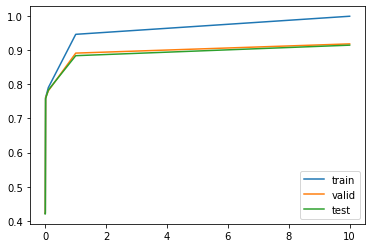

In [19]:
import matplotlib.pyplot as plt

for i in ['train', 'valid', 'test']:
  plt.plot(df_score['C'], df_score[i])

plt.legend(['train', 'valid', 'test'])
plt.show()

In [20]:
df_score

,C,train,valid,test
0,1.000000e-07,0.421945,0.422039,0.420540
0,1.000000e-06,0.421945,0.422039,0.420540
0,1.000000e-05,0.421945,0.422039,0.420540
0,1.000000e-04,0.421945,0.422039,0.420540
0,1.000000e-03,0.431690,0.433283,0.425037
0,1.000000e-02,0.760307,0.760120,0.757121
0,1.000000e-01,0.789824,0.780360,0.782609
0,1.000000e+00,0.945465,0.890555,0.883058
0,1.000000e+01,0.998313,0.917541,0.913793


59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [21]:
!pip install optuna
!pip install lightgbm==3.3.1

In [22]:
# high parameter for logistical regression
import optuna

def objective(trial):

    C = trial.suggest_loguniform("C", 1e-7, 10.0)
    solver = trial.suggest_categorical("solver", ("lbfgs", "saga"))

    clf = LogisticRegression(C=C, solver=solver)
    clf.fit(X_train, y_train)
    val_accuracy = clf.score(X_test, y_test)

    return val_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2021-12-10 06:39:33,023] A new study created in memory with name: no-name-120f3a55-1d8d-4a17-837d-13324c449060
[I 2021-12-10 06:39:33,286] Trial 0 finished with value: 0.7698650674662668 and parameters: {'C': 0.019238787010728155, 'solver': 'saga'}. Best is trial 0 with value: 0.7698650674662668.
[I 2021-12-10 06:39:33,512] Trial 1 finished with value: 0.8508245877061469 and parameters: {'C': 0.378380787433893, 'solver': 'saga'}. Best is trial 1 with value: 0.8508245877061469.
[I 2021-12-10 06:39:33,755] Trial 2 finished with value: 0.7728635682158921 and parameters: {'C': 0.024472736615574784, 'solver': 'saga'}. Best is trial 1 with value: 0.8508245877061469.
[I 2021-12-10 06:39:34,019] Trial 3 finished with value: 0.7158920539730135 and parameters: {'C': 0.0053957813438718395, 'solver': 'saga'}. Best is trial 1 with value: 0.8508245877061469.
[I 2021-12-10 06:39:34,231] Trial 4 finished with value: 0.8425787106446777 and parameters: {'C': 0.3297226296270493, 'solver': 'saga'}. Bes

In [23]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()


# df_X_train = pd.DataFrame(X_train.toarray())
# for col in df_X_train.columns:
#   df_X_train[col] = df_X_train[col].astype('float')

dtrain = lgb.Dataset(X_train, label=LE.fit_transform(y_train))
# dval = lgb.Dataset(pd.DataFrame(X_valid.toarray()), label=y_valid)

param = {'metric': 'multi_logloss',
    'objective': 'multiclass',
    'num_class': 4}

num_round = 100
bst = lgb.train(param, dtrain, num_round, 
                # valid_sets=[dval]
                )


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20953
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 961
[LightGBM] [Info] Start training from score -0.862880
[LightGBM] [Info] Start training from score -0.927551
[LightGBM] [Info] Start training from score -2.678233
[LightGBM] [Info] Start training from score -2.172879


In [24]:
X_train

<10672x14039 sparse matrix of type '<class 'numpy.float64'>'
	with 106101 stored elements in Compressed Sparse Row format>

In [25]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('train accuracy = ', accuracy_score(y_true=y_train, y_pred=y_train_pred))
print('test accuracy = ', accuracy_score(y_true=y_test, y_pred=y_test_pred))

train accuracy =  0.9296289355322339
test accuracy =  0.8545727136431784


In [29]:
import numpy as np
import optuna.integration.lightgbm as lgb

from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


dtrain = lgb.Dataset(X_train, label=LE.fit_transform(y_train))
dval = lgb.Dataset(X_valid, label=LE.fit_transform(y_valid))

param = {
      "objective": "multiclass",
      "num_class": 4,
      "metric": "multi_logloss",
      "verbosity": -1,
      "boosting_type": "gbdt",
      }
model = lgb.train(
    param,
    dtrain,
    valid_sets=dval,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

[I 2021-12-10 06:49:39,597] A new study created in memory with name: no-name-18484dd0-a9ea-4226-972a-041a5dfc9e8a


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0561
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.982868
[3]	valid_0's multi_logloss: 0.926613
[4]	valid_0's multi_logloss: 0.879918
[5]	valid_0's multi_logloss: 0.838651
[6]	valid_0's multi_logloss: 0.802966
[7]	valid_0's multi_logloss: 0.772005
[8]	valid_0's multi_logloss: 0.745952
[9]	valid_0's multi_logloss: 0.721293
[10]	valid_0's multi_logloss: 0.699946
[11]	valid_0's multi_logloss: 0.681043
[12]	valid_0's multi_logloss: 0.6639
[13]	valid_0's multi_logloss: 0.648697
[14]	valid_0's multi_logloss: 0.634929
[15]	valid_0's multi_logloss: 0.622188
[16]	valid_0's multi_logloss: 0.61063
[17]	valid_0's multi_logloss: 0.599364
[18]	valid_0's multi_logloss: 0.58837
[19]	valid_0's multi_logloss: 0.579338
[20]	valid_0's multi_logloss: 0.569811
[21]	valid_0's multi_logloss: 0.561372
[22]	valid_0's multi_logloss: 0.553249
[23]	valid_0's multi_logloss: 0.546399
[24]	valid_0's multi_logloss: 0.539299
[25]	valid_0's mu



feature_fraction, val_score: 0.318677:   0%|          | 0/7 [00:34<?, ?it/s]

feature_fraction, val_score: 0.318677:  14%|#4        | 1/7 [00:34<03:28, 34.74s/it][I 2021-12-10 06:50:14,378] Trial 0 finished with value: 0.31867720194261656 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.31867720194261656.


feature_fraction, val_score: 0.318677:  14%|#4        | 1/7 [00:34<03:28, 34.74s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.09116
[2]	valid_0's multi_logloss: 1.03002
[3]	valid_0's multi_logloss: 0.974096
[4]	valid_0's multi_logloss: 0.928258
[5]	valid_0's multi_logloss: 0.890042
[6]	valid_0's multi_logloss: 0.855443
[7]	valid_0's multi_logloss: 0.8256
[8]	valid_0's multi_logloss: 0.797717
[9]	valid_0's multi_logloss: 0.772724
[10]	valid_0's multi_logloss: 0.748415
[11]	valid_0's multi_logloss: 0.726154
[12]	valid_0's multi_logloss: 0.707367
[13]	valid_0's multi_logloss: 0.689372
[14]	valid_0's multi_logloss: 0.671751
[15]	valid_0's multi_logloss: 0.656505
[16]	valid_0's multi_logloss: 0.641405
[17]	valid_0's multi_logloss: 0.628398
[18]	valid_0's multi_logloss: 0.616683
[19]	valid_0's multi_logloss: 0.604002
[20]	valid_0's multi_logloss: 0.592602
[21]	valid_0's multi_logloss: 0.582463
[22]	valid_0's multi_logloss: 0.572472
[23]	valid_0's multi_logloss: 0.564979
[24]	valid_0's multi_logloss: 0.556032
[25]	valid_0's multi_logloss: 0.547792
[26]	valid_0's multi_logloss: 0.54017




feature_fraction, val_score: 0.318677:  14%|#4        | 1/7 [02:17<03:28, 34.74s/it]

feature_fraction, val_score: 0.318677:  29%|##8       | 2/7 [02:17<06:14, 74.93s/it][I 2021-12-10 06:51:57,467] Trial 1 finished with value: 0.31867720194261656 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.31867720194261656.


feature_fraction, val_score: 0.318677:  29%|##8       | 2/7 [02:17<06:14, 74.93s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08033
[2]	valid_0's multi_logloss: 1.0094
[3]	valid_0's multi_logloss: 0.948554
[4]	valid_0's multi_logloss: 0.902112
[5]	valid_0's multi_logloss: 0.864583
[6]	valid_0's multi_logloss: 0.827798
[7]	valid_0's multi_logloss: 0.7995
[8]	valid_0's multi_logloss: 0.770751
[9]	valid_0's multi_logloss: 0.744704
[10]	valid_0's multi_logloss: 0.723454
[11]	valid_0's multi_logloss: 0.703536
[12]	valid_0's multi_logloss: 0.684789
[13]	valid_0's multi_logloss: 0.666875
[14]	valid_0's multi_logloss: 0.650072
[15]	valid_0's multi_logloss: 0.635566
[16]	valid_0's multi_logloss: 0.621855
[17]	valid_0's multi_logloss: 0.610449
[18]	valid_0's multi_logloss: 0.598251
[19]	valid_0's multi_logloss: 0.588347
[20]	valid_0's multi_logloss: 0.578113
[21]	valid_0's multi_logloss: 0.568659
[22]	valid_0's multi_logloss: 0.560008
[23]	valid_0's multi_logloss: 0.552247
[24]	valid_0's multi_logloss: 0.544742
[25]	valid_0's multi_logloss: 0.537351
[26]	valid_0's multi_logloss: 0.529982




feature_fraction, val_score: 0.314981:  29%|##8       | 2/7 [02:51<06:14, 74.93s/it]

feature_fraction, val_score: 0.314981:  43%|####2     | 3/7 [02:51<03:43, 55.91s/it][I 2021-12-10 06:52:30,719] Trial 2 finished with value: 0.3149809212838729 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.3149809212838729.


feature_fraction, val_score: 0.314981:  43%|####2     | 3/7 [02:51<03:43, 55.91s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08458
[2]	valid_0's multi_logloss: 1.01748
[3]	valid_0's multi_logloss: 0.958701
[4]	valid_0's multi_logloss: 0.913823
[5]	valid_0's multi_logloss: 0.874205
[6]	valid_0's multi_logloss: 0.839179
[7]	valid_0's multi_logloss: 0.810423
[8]	valid_0's multi_logloss: 0.780147
[9]	valid_0's multi_logloss: 0.756083
[10]	valid_0's multi_logloss: 0.733522
[11]	valid_0's multi_logloss: 0.712097
[12]	valid_0's multi_logloss: 0.692558
[13]	valid_0's multi_logloss: 0.674265
[14]	valid_0's multi_logloss: 0.657593
[15]	valid_0's multi_logloss: 0.641679
[16]	valid_0's multi_logloss: 0.627785
[17]	valid_0's multi_logloss: 0.615007
[18]	valid_0's multi_logloss: 0.603461
[19]	valid_0's multi_logloss: 0.591365
[20]	valid_0's multi_logloss: 0.581153
[21]	valid_0's multi_logloss: 0.571322
[22]	valid_0's multi_logloss: 0.561899
[23]	valid_0's multi_logloss: 0.554311
[24]	valid_0's multi_logloss: 0.54652
[25]	valid_0's multi_logloss: 0.539685
[26]	valid_0's multi_logloss: 0.53182



feature_fraction, val_score: 0.314981:  43%|####2     | 3/7 [04:10<03:43, 55.91s/it]

feature_fraction, val_score: 0.314981:  57%|#####7    | 4/7 [04:10<03:15, 65.33s/it][I 2021-12-10 06:53:50,503] Trial 3 finished with value: 0.3149809212838729 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.3149809212838729.


feature_fraction, val_score: 0.314981:  57%|#####7    | 4/7 [04:10<03:15, 65.33s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.09872
[2]	valid_0's multi_logloss: 1.04761
[3]	valid_0's multi_logloss: 0.996419
[4]	valid_0's multi_logloss: 0.95509
[5]	valid_0's multi_logloss: 0.919946
[6]	valid_0's multi_logloss: 0.881982
[7]	valid_0's multi_logloss: 0.852549
[8]	valid_0's multi_logloss: 0.823888
[9]	valid_0's multi_logloss: 0.797667
[10]	valid_0's multi_logloss: 0.772651
[11]	valid_0's multi_logloss: 0.750427
[12]	valid_0's multi_logloss: 0.729555
[13]	valid_0's multi_logloss: 0.711695
[14]	valid_0's multi_logloss: 0.694654
[15]	valid_0's multi_logloss: 0.677054
[16]	valid_0's multi_logloss: 0.660426
[17]	valid_0's multi_logloss: 0.647166
[18]	valid_0's multi_logloss: 0.635051
[19]	valid_0's multi_logloss: 0.622187
[20]	valid_0's multi_logloss: 0.610603
[21]	valid_0's multi_logloss: 0.598894
[22]	valid_0's multi_logloss: 0.589199
[23]	valid_0's multi_logloss: 0.580528
[24]	valid_0's multi_logloss: 0.570668
[25]	valid_0's multi_logloss: 0.562952
[26]	valid_0's multi_logloss: 0.55430



feature_fraction, val_score: 0.314981:  57%|#####7    | 4/7 [05:42<03:15, 65.33s/it]

feature_fraction, val_score: 0.314981:  71%|#######1  | 5/7 [05:42<02:29, 74.86s/it][I 2021-12-10 06:55:22,257] Trial 4 finished with value: 0.3149809212838729 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.3149809212838729.


feature_fraction, val_score: 0.314981:  71%|#######1  | 5/7 [05:42<02:29, 74.86s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06397
[2]	valid_0's multi_logloss: 0.989435
[3]	valid_0's multi_logloss: 0.933425
[4]	valid_0's multi_logloss: 0.886697
[5]	valid_0's multi_logloss: 0.845022
[6]	valid_0's multi_logloss: 0.807744
[7]	valid_0's multi_logloss: 0.778633
[8]	valid_0's multi_logloss: 0.749888
[9]	valid_0's multi_logloss: 0.725169
[10]	valid_0's multi_logloss: 0.704936
[11]	valid_0's multi_logloss: 0.68672
[12]	valid_0's multi_logloss: 0.668873
[13]	valid_0's multi_logloss: 0.653635
[14]	valid_0's multi_logloss: 0.638909
[15]	valid_0's multi_logloss: 0.625859
[16]	valid_0's multi_logloss: 0.61334
[17]	valid_0's multi_logloss: 0.601566
[18]	valid_0's multi_logloss: 0.591022
[19]	valid_0's multi_logloss: 0.581634
[20]	valid_0's multi_logloss: 0.572612
[21]	valid_0's multi_logloss: 0.564542
[22]	valid_0's multi_logloss: 0.555919
[23]	valid_0's multi_logloss: 0.548263
[24]	valid_0's multi_logloss: 0.540832
[25]	valid_0's multi_logloss: 0.533454
[26]	valid_0's multi_logloss: 0.52698



feature_fraction, val_score: 0.314981:  71%|#######1  | 5/7 [06:19<02:29, 74.86s/it]

feature_fraction, val_score: 0.314981:  86%|########5 | 6/7 [06:19<01:01, 61.94s/it][I 2021-12-10 06:55:59,122] Trial 5 finished with value: 0.3149809212838729 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.3149809212838729.


feature_fraction, val_score: 0.314981:  86%|########5 | 6/7 [06:19<01:01, 61.94s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07073
[2]	valid_0's multi_logloss: 0.99692
[3]	valid_0's multi_logloss: 0.939452
[4]	valid_0's multi_logloss: 0.894109
[5]	valid_0's multi_logloss: 0.854134
[6]	valid_0's multi_logloss: 0.818067
[7]	valid_0's multi_logloss: 0.788047
[8]	valid_0's multi_logloss: 0.760783
[9]	valid_0's multi_logloss: 0.733786
[10]	valid_0's multi_logloss: 0.712132
[11]	valid_0's multi_logloss: 0.691436
[12]	valid_0's multi_logloss: 0.673986
[13]	valid_0's multi_logloss: 0.657683
[14]	valid_0's multi_logloss: 0.641361
[15]	valid_0's multi_logloss: 0.628782
[16]	valid_0's multi_logloss: 0.615752
[17]	valid_0's multi_logloss: 0.60491
[18]	valid_0's multi_logloss: 0.593168
[19]	valid_0's multi_logloss: 0.583906
[20]	valid_0's multi_logloss: 0.573041
[21]	valid_0's multi_logloss: 0.564082
[22]	valid_0's multi_logloss: 0.554924
[23]	valid_0's multi_logloss: 0.548372
[24]	valid_0's multi_logloss: 0.541324
[25]	valid_0's multi_logloss: 0.53454
[26]	valid_0's multi_logloss: 0.527974



feature_fraction, val_score: 0.314981:  86%|########5 | 6/7 [06:54<01:01, 61.94s/it]

feature_fraction, val_score: 0.314981: 100%|##########| 7/7 [06:54<00:00, 59.27s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.314981:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06622
[2]	valid_0's multi_logloss: 0.989232
[3]	valid_0's multi_logloss: 0.920884
[4]	valid_0's multi_logloss: 0.868977
[5]	valid_0's multi_logloss: 0.826017
[6]	valid_0's multi_logloss: 0.785412
[7]	valid_0's multi_logloss: 0.753416
[8]	valid_0's multi_logloss: 0.719248
[9]	valid_0's multi_logloss: 0.690028
[10]	valid_0's multi_logloss: 0.666723
[11]	valid_0's multi_logloss: 0.644078
[12]	valid_0's multi_logloss: 0.622803
[13]	valid_0's multi_logloss: 0.604464
[14]	valid_0's multi_logloss: 0.584841
[15]	valid_0's multi_logloss: 0.566684
[16]	valid_0's multi_logloss: 0.550922
[17]	valid_0's multi_logloss: 0.536507
[18]	valid_0's multi_logloss: 0.522619
[19]	valid_0's multi_logloss: 0.509659
[20]	valid_0's multi_logloss: 0.497747
[21]	valid_0's multi_logloss: 0.487132
[22]	valid_0's multi_logloss: 0.476653
[23]	valid_0's multi_logloss: 0.468554
[24]	valid_0's multi_logloss: 0.459154
[25]	valid_0's multi_logloss: 0.4502
[26]	valid_0's multi_logloss: 0.44183



num_leaves, val_score: 0.314981:   0%|          | 0/20 [01:04<?, ?it/s]

num_leaves, val_score: 0.314981:   5%|5         | 1/20 [01:04<20:21, 64.31s/it][I 2021-12-10 06:57:38,847] Trial 7 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 74}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:   5%|5         | 1/20 [01:04<20:21, 64.31s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06178
[2]	valid_0's multi_logloss: 0.981244
[3]	valid_0's multi_logloss: 0.909855
[4]	valid_0's multi_logloss: 0.859252
[5]	valid_0's multi_logloss: 0.815079
[6]	valid_0's multi_logloss: 0.773207
[7]	valid_0's multi_logloss: 0.738779
[8]	valid_0's multi_logloss: 0.704334
[9]	valid_0's multi_logloss: 0.674095
[10]	valid_0's multi_logloss: 0.650014
[11]	valid_0's multi_logloss: 0.627153
[12]	valid_0's multi_logloss: 0.605482
[13]	valid_0's multi_logloss: 0.587354
[14]	valid_0's multi_logloss: 0.566479
[15]	valid_0's multi_logloss: 0.548263
[16]	valid_0's multi_logloss: 0.533994
[17]	valid_0's multi_logloss: 0.518808
[18]	valid_0's multi_logloss: 0.503915
[19]	valid_0's multi_logloss: 0.490906
[20]	valid_0's multi_logloss: 0.479004
[21]	valid_0's multi_logloss: 0.468688
[22]	valid_0's multi_logloss: 0.457383
[23]	valid_0's multi_logloss: 0.447827
[24]	valid_0's multi_logloss: 0.438264
[25]	valid_0's multi_logloss: 0.428462
[26]	valid_0's multi_logloss: 0.420



num_leaves, val_score: 0.314981:   5%|5         | 1/20 [02:39<20:21, 64.31s/it]

num_leaves, val_score: 0.314981:  10%|#         | 2/20 [02:39<24:43, 82.44s/it][I 2021-12-10 06:59:13,977] Trial 8 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 186}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  10%|#         | 2/20 [02:39<24:43, 82.44s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06254
[2]	valid_0's multi_logloss: 0.982911
[3]	valid_0's multi_logloss: 0.911503
[4]	valid_0's multi_logloss: 0.859147
[5]	valid_0's multi_logloss: 0.814877
[6]	valid_0's multi_logloss: 0.773244
[7]	valid_0's multi_logloss: 0.739303
[8]	valid_0's multi_logloss: 0.704954
[9]	valid_0's multi_logloss: 0.674857
[10]	valid_0's multi_logloss: 0.651156
[11]	valid_0's multi_logloss: 0.629272
[12]	valid_0's multi_logloss: 0.608071
[13]	valid_0's multi_logloss: 0.589061
[14]	valid_0's multi_logloss: 0.569064
[15]	valid_0's multi_logloss: 0.550994
[16]	valid_0's multi_logloss: 0.535839
[17]	valid_0's multi_logloss: 0.521353
[18]	valid_0's multi_logloss: 0.506673
[19]	valid_0's multi_logloss: 0.493632
[20]	valid_0's multi_logloss: 0.481779
[21]	valid_0's multi_logloss: 0.469695
[22]	valid_0's multi_logloss: 0.458373
[23]	valid_0's multi_logloss: 0.448623
[24]	valid_0's multi_logloss: 0.438648
[25]	valid_0's multi_logloss: 0.429117
[26]	valid_0's multi_logloss: 0.421



num_leaves, val_score: 0.314981:  10%|#         | 2/20 [04:04<24:43, 82.44s/it]

num_leaves, val_score: 0.314981:  15%|#5        | 3/20 [04:04<23:45, 83.83s/it][I 2021-12-10 07:00:39,455] Trial 9 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 137}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  15%|#5        | 3/20 [04:04<23:45, 83.83s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07846
[2]	valid_0's multi_logloss: 1.00695
[3]	valid_0's multi_logloss: 0.944555
[4]	valid_0's multi_logloss: 0.89701
[5]	valid_0's multi_logloss: 0.856409
[6]	valid_0's multi_logloss: 0.818452
[7]	valid_0's multi_logloss: 0.78973
[8]	valid_0's multi_logloss: 0.760893
[9]	valid_0's multi_logloss: 0.73517
[10]	valid_0's multi_logloss: 0.713547
[11]	valid_0's multi_logloss: 0.692181
[12]	valid_0's multi_logloss: 0.672894
[13]	valid_0's multi_logloss: 0.655093
[14]	valid_0's multi_logloss: 0.637557
[15]	valid_0's multi_logloss: 0.623205
[16]	valid_0's multi_logloss: 0.60938
[17]	valid_0's multi_logloss: 0.597018
[18]	valid_0's multi_logloss: 0.583809
[19]	valid_0's multi_logloss: 0.572841
[20]	valid_0's multi_logloss: 0.562187
[21]	valid_0's multi_logloss: 0.551222
[22]	valid_0's multi_logloss: 0.542412
[23]	valid_0's multi_logloss: 0.534629
[24]	valid_0's multi_logloss: 0.527275
[25]	valid_0's multi_logloss: 0.520333
[26]	valid_0's multi_logloss: 0.514461
[



num_leaves, val_score: 0.314981:  15%|#5        | 3/20 [04:42<23:45, 83.83s/it]

num_leaves, val_score: 0.314981:  20%|##        | 4/20 [04:42<17:26, 65.39s/it][I 2021-12-10 07:01:16,577] Trial 10 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 35}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  20%|##        | 4/20 [04:42<17:26, 65.39s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07082
[2]	valid_0's multi_logloss: 0.995146
[3]	valid_0's multi_logloss: 0.928694
[4]	valid_0's multi_logloss: 0.879231
[5]	valid_0's multi_logloss: 0.837378
[6]	valid_0's multi_logloss: 0.797172
[7]	valid_0's multi_logloss: 0.766159
[8]	valid_0's multi_logloss: 0.734109
[9]	valid_0's multi_logloss: 0.704978
[10]	valid_0's multi_logloss: 0.683
[11]	valid_0's multi_logloss: 0.661289
[12]	valid_0's multi_logloss: 0.641119
[13]	valid_0's multi_logloss: 0.622817
[14]	valid_0's multi_logloss: 0.603849
[15]	valid_0's multi_logloss: 0.58667
[16]	valid_0's multi_logloss: 0.572223
[17]	valid_0's multi_logloss: 0.558707
[18]	valid_0's multi_logloss: 0.545459
[19]	valid_0's multi_logloss: 0.533877
[20]	valid_0's multi_logloss: 0.522301
[21]	valid_0's multi_logloss: 0.512033
[22]	valid_0's multi_logloss: 0.502094
[23]	valid_0's multi_logloss: 0.493949
[24]	valid_0's multi_logloss: 0.485562
[25]	valid_0's multi_logloss: 0.477857
[26]	valid_0's multi_logloss: 0.470363




num_leaves, val_score: 0.314981:  20%|##        | 4/20 [05:34<17:26, 65.39s/it]

num_leaves, val_score: 0.314981:  25%|##5       | 5/20 [05:34<15:08, 60.57s/it][I 2021-12-10 07:02:08,606] Trial 11 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 54}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  25%|##5       | 5/20 [05:34<15:08, 60.57s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06163
[2]	valid_0's multi_logloss: 0.981543
[3]	valid_0's multi_logloss: 0.910444
[4]	valid_0's multi_logloss: 0.859988
[5]	valid_0's multi_logloss: 0.815452
[6]	valid_0's multi_logloss: 0.774843
[7]	valid_0's multi_logloss: 0.740646
[8]	valid_0's multi_logloss: 0.706432
[9]	valid_0's multi_logloss: 0.676844
[10]	valid_0's multi_logloss: 0.653515
[11]	valid_0's multi_logloss: 0.631656
[12]	valid_0's multi_logloss: 0.610426
[13]	valid_0's multi_logloss: 0.591627
[14]	valid_0's multi_logloss: 0.571817
[15]	valid_0's multi_logloss: 0.554287
[16]	valid_0's multi_logloss: 0.540383
[17]	valid_0's multi_logloss: 0.525902
[18]	valid_0's multi_logloss: 0.512178
[19]	valid_0's multi_logloss: 0.499667
[20]	valid_0's multi_logloss: 0.48822
[21]	valid_0's multi_logloss: 0.475712
[22]	valid_0's multi_logloss: 0.462915
[23]	valid_0's multi_logloss: 0.45423
[24]	valid_0's multi_logloss: 0.446829
[25]	valid_0's multi_logloss: 0.437133
[26]	valid_0's multi_logloss: 0.42852



num_leaves, val_score: 0.314981:  25%|##5       | 5/20 [07:17<15:08, 60.57s/it]

num_leaves, val_score: 0.314981:  30%|###       | 6/20 [07:17<17:29, 74.98s/it][I 2021-12-10 07:03:51,569] Trial 12 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 232}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  30%|###       | 6/20 [07:17<17:29, 74.98s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08445
[2]	valid_0's multi_logloss: 1.01698
[3]	valid_0's multi_logloss: 0.959747
[4]	valid_0's multi_logloss: 0.915379
[5]	valid_0's multi_logloss: 0.879552
[6]	valid_0's multi_logloss: 0.84608
[7]	valid_0's multi_logloss: 0.818605
[8]	valid_0's multi_logloss: 0.79201
[9]	valid_0's multi_logloss: 0.766949
[10]	valid_0's multi_logloss: 0.746361
[11]	valid_0's multi_logloss: 0.728353
[12]	valid_0's multi_logloss: 0.709656
[13]	valid_0's multi_logloss: 0.69397
[14]	valid_0's multi_logloss: 0.678268
[15]	valid_0's multi_logloss: 0.664449
[16]	valid_0's multi_logloss: 0.65153
[17]	valid_0's multi_logloss: 0.639851
[18]	valid_0's multi_logloss: 0.628658
[19]	valid_0's multi_logloss: 0.617697
[20]	valid_0's multi_logloss: 0.60666
[21]	valid_0's multi_logloss: 0.597014
[22]	valid_0's multi_logloss: 0.588635
[23]	valid_0's multi_logloss: 0.581136
[24]	valid_0's multi_logloss: 0.573545
[25]	valid_0's multi_logloss: 0.566367
[26]	valid_0's multi_logloss: 0.560202
[2



num_leaves, val_score: 0.314981:  30%|###       | 6/20 [07:44<17:29, 74.98s/it]

num_leaves, val_score: 0.314981:  35%|###5      | 7/20 [07:44<12:53, 59.52s/it][I 2021-12-10 07:04:19,259] Trial 13 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 24}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  35%|###5      | 7/20 [07:44<12:53, 59.52s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06245
[2]	valid_0's multi_logloss: 0.982999
[3]	valid_0's multi_logloss: 0.911797
[4]	valid_0's multi_logloss: 0.860853
[5]	valid_0's multi_logloss: 0.817478
[6]	valid_0's multi_logloss: 0.776336
[7]	valid_0's multi_logloss: 0.742479
[8]	valid_0's multi_logloss: 0.708316
[9]	valid_0's multi_logloss: 0.677898
[10]	valid_0's multi_logloss: 0.654035
[11]	valid_0's multi_logloss: 0.631493
[12]	valid_0's multi_logloss: 0.61003
[13]	valid_0's multi_logloss: 0.592143
[14]	valid_0's multi_logloss: 0.571686
[15]	valid_0's multi_logloss: 0.553505
[16]	valid_0's multi_logloss: 0.538717
[17]	valid_0's multi_logloss: 0.525202
[18]	valid_0's multi_logloss: 0.510145
[19]	valid_0's multi_logloss: 0.497495
[20]	valid_0's multi_logloss: 0.485796
[21]	valid_0's multi_logloss: 0.473763
[22]	valid_0's multi_logloss: 0.46265
[23]	valid_0's multi_logloss: 0.452608
[24]	valid_0's multi_logloss: 0.442206
[25]	valid_0's multi_logloss: 0.433702
[26]	valid_0's multi_logloss: 0.42573



num_leaves, val_score: 0.314981:  35%|###5      | 7/20 [09:11<12:53, 59.52s/it]

num_leaves, val_score: 0.314981:  40%|####      | 8/20 [09:11<13:39, 68.28s/it][I 2021-12-10 07:05:46,292] Trial 14 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 141}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  40%|####      | 8/20 [09:11<13:39, 68.28s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06179
[2]	valid_0's multi_logloss: 0.981399
[3]	valid_0's multi_logloss: 0.910527
[4]	valid_0's multi_logloss: 0.858567
[5]	valid_0's multi_logloss: 0.813641
[6]	valid_0's multi_logloss: 0.771492
[7]	valid_0's multi_logloss: 0.737175
[8]	valid_0's multi_logloss: 0.703408
[9]	valid_0's multi_logloss: 0.673597
[10]	valid_0's multi_logloss: 0.648978
[11]	valid_0's multi_logloss: 0.627059
[12]	valid_0's multi_logloss: 0.605874
[13]	valid_0's multi_logloss: 0.588022
[14]	valid_0's multi_logloss: 0.567574
[15]	valid_0's multi_logloss: 0.549967
[16]	valid_0's multi_logloss: 0.536795
[17]	valid_0's multi_logloss: 0.522778
[18]	valid_0's multi_logloss: 0.507548
[19]	valid_0's multi_logloss: 0.493831
[20]	valid_0's multi_logloss: 0.481868
[21]	valid_0's multi_logloss: 0.470698
[22]	valid_0's multi_logloss: 0.45937
[23]	valid_0's multi_logloss: 0.450651
[24]	valid_0's multi_logloss: 0.440581
[25]	valid_0's multi_logloss: 0.432177
[26]	valid_0's multi_logloss: 0.4236



num_leaves, val_score: 0.314981:  40%|####      | 8/20 [10:47<13:39, 68.28s/it]

num_leaves, val_score: 0.314981:  45%|####5     | 9/20 [10:47<14:05, 76.91s/it][I 2021-12-10 07:07:22,163] Trial 15 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  45%|####5     | 9/20 [10:47<14:05, 76.91s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06868
[2]	valid_0's multi_logloss: 0.992547
[3]	valid_0's multi_logloss: 0.923245
[4]	valid_0's multi_logloss: 0.873097
[5]	valid_0's multi_logloss: 0.830419
[6]	valid_0's multi_logloss: 0.789799
[7]	valid_0's multi_logloss: 0.758502
[8]	valid_0's multi_logloss: 0.725483
[9]	valid_0's multi_logloss: 0.696218
[10]	valid_0's multi_logloss: 0.672952
[11]	valid_0's multi_logloss: 0.650968
[12]	valid_0's multi_logloss: 0.629845
[13]	valid_0's multi_logloss: 0.611689
[14]	valid_0's multi_logloss: 0.592343
[15]	valid_0's multi_logloss: 0.574478
[16]	valid_0's multi_logloss: 0.559937
[17]	valid_0's multi_logloss: 0.545246
[18]	valid_0's multi_logloss: 0.532107
[19]	valid_0's multi_logloss: 0.519566
[20]	valid_0's multi_logloss: 0.506575
[21]	valid_0's multi_logloss: 0.495944
[22]	valid_0's multi_logloss: 0.485988
[23]	valid_0's multi_logloss: 0.478275
[24]	valid_0's multi_logloss: 0.469718
[25]	valid_0's multi_logloss: 0.461099
[26]	valid_0's multi_logloss: 0.454



num_leaves, val_score: 0.314981:  45%|####5     | 9/20 [11:45<14:05, 76.91s/it]

num_leaves, val_score: 0.314981:  50%|#####     | 10/20 [11:46<11:51, 71.19s/it][I 2021-12-10 07:08:20,545] Trial 16 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 64}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  50%|#####     | 10/20 [11:46<11:51, 71.19s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06445
[2]	valid_0's multi_logloss: 0.986466
[3]	valid_0's multi_logloss: 0.916048
[4]	valid_0's multi_logloss: 0.864762
[5]	valid_0's multi_logloss: 0.82113
[6]	valid_0's multi_logloss: 0.779426
[7]	valid_0's multi_logloss: 0.74716
[8]	valid_0's multi_logloss: 0.71419
[9]	valid_0's multi_logloss: 0.684884
[10]	valid_0's multi_logloss: 0.660671
[11]	valid_0's multi_logloss: 0.637854
[12]	valid_0's multi_logloss: 0.616293
[13]	valid_0's multi_logloss: 0.597113
[14]	valid_0's multi_logloss: 0.577875
[15]	valid_0's multi_logloss: 0.560098
[16]	valid_0's multi_logloss: 0.544574
[17]	valid_0's multi_logloss: 0.530071
[18]	valid_0's multi_logloss: 0.516092
[19]	valid_0's multi_logloss: 0.50386
[20]	valid_0's multi_logloss: 0.492178
[21]	valid_0's multi_logloss: 0.481064
[22]	valid_0's multi_logloss: 0.470144
[23]	valid_0's multi_logloss: 0.461053
[24]	valid_0's multi_logloss: 0.452148
[25]	valid_0's multi_logloss: 0.442358
[26]	valid_0's multi_logloss: 0.433805




num_leaves, val_score: 0.314981:  50%|#####     | 10/20 [12:57<11:51, 71.19s/it]

num_leaves, val_score: 0.314981:  55%|#####5    | 11/20 [12:57<10:42, 71.40s/it][I 2021-12-10 07:09:32,410] Trial 17 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 90}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  55%|#####5    | 11/20 [12:57<10:42, 71.40s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06178
[2]	valid_0's multi_logloss: 0.981156
[3]	valid_0's multi_logloss: 0.909909
[4]	valid_0's multi_logloss: 0.859501
[5]	valid_0's multi_logloss: 0.81542
[6]	valid_0's multi_logloss: 0.773988
[7]	valid_0's multi_logloss: 0.739971
[8]	valid_0's multi_logloss: 0.705576
[9]	valid_0's multi_logloss: 0.675296
[10]	valid_0's multi_logloss: 0.650969
[11]	valid_0's multi_logloss: 0.6282
[12]	valid_0's multi_logloss: 0.607261
[13]	valid_0's multi_logloss: 0.589287
[14]	valid_0's multi_logloss: 0.569539
[15]	valid_0's multi_logloss: 0.55288
[16]	valid_0's multi_logloss: 0.539154
[17]	valid_0's multi_logloss: 0.525585
[18]	valid_0's multi_logloss: 0.509642
[19]	valid_0's multi_logloss: 0.496588
[20]	valid_0's multi_logloss: 0.482355
[21]	valid_0's multi_logloss: 0.47087
[22]	valid_0's multi_logloss: 0.459422
[23]	valid_0's multi_logloss: 0.449949
[24]	valid_0's multi_logloss: 0.440065
[25]	valid_0's multi_logloss: 0.430879
[26]	valid_0's multi_logloss: 0.422191
[



num_leaves, val_score: 0.314981:  55%|#####5    | 11/20 [14:34<10:42, 71.40s/it]

num_leaves, val_score: 0.314981:  60%|######    | 12/20 [14:34<10:32, 79.08s/it][I 2021-12-10 07:11:09,059] Trial 18 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 190}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  60%|######    | 12/20 [14:34<10:32, 79.08s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06361
[2]	valid_0's multi_logloss: 0.98513
[3]	valid_0's multi_logloss: 0.914917
[4]	valid_0's multi_logloss: 0.862822
[5]	valid_0's multi_logloss: 0.818924
[6]	valid_0's multi_logloss: 0.778081
[7]	valid_0's multi_logloss: 0.74407
[8]	valid_0's multi_logloss: 0.710751
[9]	valid_0's multi_logloss: 0.681119
[10]	valid_0's multi_logloss: 0.657242
[11]	valid_0's multi_logloss: 0.634558
[12]	valid_0's multi_logloss: 0.612528
[13]	valid_0's multi_logloss: 0.594309
[14]	valid_0's multi_logloss: 0.574204
[15]	valid_0's multi_logloss: 0.555488
[16]	valid_0's multi_logloss: 0.540966
[17]	valid_0's multi_logloss: 0.525307
[18]	valid_0's multi_logloss: 0.511093
[19]	valid_0's multi_logloss: 0.497935
[20]	valid_0's multi_logloss: 0.486343
[21]	valid_0's multi_logloss: 0.475256
[22]	valid_0's multi_logloss: 0.463959
[23]	valid_0's multi_logloss: 0.45464
[24]	valid_0's multi_logloss: 0.443404
[25]	valid_0's multi_logloss: 0.43371
[26]	valid_0's multi_logloss: 0.426093




num_leaves, val_score: 0.314981:  60%|######    | 12/20 [15:52<10:32, 79.08s/it]

num_leaves, val_score: 0.314981:  65%|######5   | 13/20 [15:52<09:10, 78.63s/it][I 2021-12-10 07:12:26,662] Trial 19 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 102}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  65%|######5   | 13/20 [15:52<09:10, 78.63s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06197
[2]	valid_0's multi_logloss: 0.981643
[3]	valid_0's multi_logloss: 0.910097
[4]	valid_0's multi_logloss: 0.857821
[5]	valid_0's multi_logloss: 0.813
[6]	valid_0's multi_logloss: 0.772315
[7]	valid_0's multi_logloss: 0.737637
[8]	valid_0's multi_logloss: 0.703698
[9]	valid_0's multi_logloss: 0.67393
[10]	valid_0's multi_logloss: 0.650804
[11]	valid_0's multi_logloss: 0.628045
[12]	valid_0's multi_logloss: 0.606743
[13]	valid_0's multi_logloss: 0.588646
[14]	valid_0's multi_logloss: 0.567421
[15]	valid_0's multi_logloss: 0.549572
[16]	valid_0's multi_logloss: 0.535775
[17]	valid_0's multi_logloss: 0.521063
[18]	valid_0's multi_logloss: 0.507224
[19]	valid_0's multi_logloss: 0.494906
[20]	valid_0's multi_logloss: 0.483432
[21]	valid_0's multi_logloss: 0.471085
[22]	valid_0's multi_logloss: 0.460106
[23]	valid_0's multi_logloss: 0.450662
[24]	valid_0's multi_logloss: 0.441322
[25]	valid_0's multi_logloss: 0.431023
[26]	valid_0's multi_logloss: 0.422447




num_leaves, val_score: 0.314981:  65%|######5   | 13/20 [17:26<09:10, 78.63s/it]

num_leaves, val_score: 0.314981:  70%|#######   | 14/20 [17:26<08:20, 83.36s/it][I 2021-12-10 07:14:00,956] Trial 20 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 174}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  70%|#######   | 14/20 [17:26<08:20, 83.36s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0615
[2]	valid_0's multi_logloss: 0.981028
[3]	valid_0's multi_logloss: 0.90979
[4]	valid_0's multi_logloss: 0.859036
[5]	valid_0's multi_logloss: 0.815512
[6]	valid_0's multi_logloss: 0.77485
[7]	valid_0's multi_logloss: 0.74057
[8]	valid_0's multi_logloss: 0.706151
[9]	valid_0's multi_logloss: 0.675686
[10]	valid_0's multi_logloss: 0.652474
[11]	valid_0's multi_logloss: 0.629744
[12]	valid_0's multi_logloss: 0.608591
[13]	valid_0's multi_logloss: 0.590523
[14]	valid_0's multi_logloss: 0.570086
[15]	valid_0's multi_logloss: 0.552111
[16]	valid_0's multi_logloss: 0.538713
[17]	valid_0's multi_logloss: 0.524283
[18]	valid_0's multi_logloss: 0.510919
[19]	valid_0's multi_logloss: 0.498699
[20]	valid_0's multi_logloss: 0.486116
[21]	valid_0's multi_logloss: 0.475863
[22]	valid_0's multi_logloss: 0.464007
[23]	valid_0's multi_logloss: 0.454399
[24]	valid_0's multi_logloss: 0.443595
[25]	valid_0's multi_logloss: 0.435354
[26]	valid_0's multi_logloss: 0.427805




num_leaves, val_score: 0.314981:  70%|#######   | 14/20 [19:12<08:20, 83.36s/it]

num_leaves, val_score: 0.314981:  75%|#######5  | 15/20 [19:12<07:31, 90.25s/it][I 2021-12-10 07:15:47,163] Trial 21 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 249}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  75%|#######5  | 15/20 [19:12<07:31, 90.25s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06316
[2]	valid_0's multi_logloss: 0.984894
[3]	valid_0's multi_logloss: 0.9143
[4]	valid_0's multi_logloss: 0.861974
[5]	valid_0's multi_logloss: 0.818023
[6]	valid_0's multi_logloss: 0.77679
[7]	valid_0's multi_logloss: 0.742396
[8]	valid_0's multi_logloss: 0.70814
[9]	valid_0's multi_logloss: 0.679104
[10]	valid_0's multi_logloss: 0.655757
[11]	valid_0's multi_logloss: 0.633489
[12]	valid_0's multi_logloss: 0.61127
[13]	valid_0's multi_logloss: 0.592157
[14]	valid_0's multi_logloss: 0.572732
[15]	valid_0's multi_logloss: 0.554957
[16]	valid_0's multi_logloss: 0.539706
[17]	valid_0's multi_logloss: 0.524931
[18]	valid_0's multi_logloss: 0.510566
[19]	valid_0's multi_logloss: 0.497609
[20]	valid_0's multi_logloss: 0.485278
[21]	valid_0's multi_logloss: 0.474405
[22]	valid_0's multi_logloss: 0.462211
[23]	valid_0's multi_logloss: 0.452949
[24]	valid_0's multi_logloss: 0.442996
[25]	valid_0's multi_logloss: 0.433673
[26]	valid_0's multi_logloss: 0.424711
[



num_leaves, val_score: 0.314981:  75%|#######5  | 15/20 [20:32<07:31, 90.25s/it]

num_leaves, val_score: 0.314981:  80%|########  | 16/20 [20:32<05:48, 87.19s/it][I 2021-12-10 07:17:07,265] Trial 22 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 108}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  80%|########  | 16/20 [20:32<05:48, 87.19s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06215
[2]	valid_0's multi_logloss: 0.982271
[3]	valid_0's multi_logloss: 0.910738
[4]	valid_0's multi_logloss: 0.85898
[5]	valid_0's multi_logloss: 0.814408
[6]	valid_0's multi_logloss: 0.773273
[7]	valid_0's multi_logloss: 0.739039
[8]	valid_0's multi_logloss: 0.704431
[9]	valid_0's multi_logloss: 0.674607
[10]	valid_0's multi_logloss: 0.651129
[11]	valid_0's multi_logloss: 0.628386
[12]	valid_0's multi_logloss: 0.607591
[13]	valid_0's multi_logloss: 0.588913
[14]	valid_0's multi_logloss: 0.56846
[15]	valid_0's multi_logloss: 0.550637
[16]	valid_0's multi_logloss: 0.536777
[17]	valid_0's multi_logloss: 0.523297
[18]	valid_0's multi_logloss: 0.508431
[19]	valid_0's multi_logloss: 0.496755
[20]	valid_0's multi_logloss: 0.483943
[21]	valid_0's multi_logloss: 0.472079
[22]	valid_0's multi_logloss: 0.461406
[23]	valid_0's multi_logloss: 0.451238
[24]	valid_0's multi_logloss: 0.440844
[25]	valid_0's multi_logloss: 0.431825
[26]	valid_0's multi_logloss: 0.42338



num_leaves, val_score: 0.314981:  80%|########  | 16/20 [22:05<05:48, 87.19s/it]

num_leaves, val_score: 0.314981:  85%|########5 | 17/20 [22:05<04:26, 88.83s/it][I 2021-12-10 07:18:39,891] Trial 23 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 161}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  85%|########5 | 17/20 [22:05<04:26, 88.83s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06152
[2]	valid_0's multi_logloss: 0.981131
[3]	valid_0's multi_logloss: 0.910037
[4]	valid_0's multi_logloss: 0.859508
[5]	valid_0's multi_logloss: 0.815613
[6]	valid_0's multi_logloss: 0.774704
[7]	valid_0's multi_logloss: 0.741021
[8]	valid_0's multi_logloss: 0.706444
[9]	valid_0's multi_logloss: 0.67561
[10]	valid_0's multi_logloss: 0.65262
[11]	valid_0's multi_logloss: 0.630264
[12]	valid_0's multi_logloss: 0.608697
[13]	valid_0's multi_logloss: 0.590606
[14]	valid_0's multi_logloss: 0.570537
[15]	valid_0's multi_logloss: 0.552793
[16]	valid_0's multi_logloss: 0.538746
[17]	valid_0's multi_logloss: 0.525127
[18]	valid_0's multi_logloss: 0.512365
[19]	valid_0's multi_logloss: 0.498316
[20]	valid_0's multi_logloss: 0.486159
[21]	valid_0's multi_logloss: 0.475495
[22]	valid_0's multi_logloss: 0.463931
[23]	valid_0's multi_logloss: 0.455246
[24]	valid_0's multi_logloss: 0.444758
[25]	valid_0's multi_logloss: 0.436079
[26]	valid_0's multi_logloss: 0.42798



num_leaves, val_score: 0.314981:  85%|########5 | 17/20 [23:52<04:26, 88.83s/it]

num_leaves, val_score: 0.314981:  90%|######### | 18/20 [23:52<03:08, 94.26s/it][I 2021-12-10 07:20:26,803] Trial 24 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 255}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  90%|######### | 18/20 [23:52<03:08, 94.26s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06427
[2]	valid_0's multi_logloss: 0.986238
[3]	valid_0's multi_logloss: 0.915993
[4]	valid_0's multi_logloss: 0.864527
[5]	valid_0's multi_logloss: 0.821186
[6]	valid_0's multi_logloss: 0.779958
[7]	valid_0's multi_logloss: 0.746535
[8]	valid_0's multi_logloss: 0.71278
[9]	valid_0's multi_logloss: 0.681672
[10]	valid_0's multi_logloss: 0.657796
[11]	valid_0's multi_logloss: 0.634322
[12]	valid_0's multi_logloss: 0.611946
[13]	valid_0's multi_logloss: 0.593544
[14]	valid_0's multi_logloss: 0.574495
[15]	valid_0's multi_logloss: 0.556276
[16]	valid_0's multi_logloss: 0.540532
[17]	valid_0's multi_logloss: 0.526024
[18]	valid_0's multi_logloss: 0.51168
[19]	valid_0's multi_logloss: 0.498101
[20]	valid_0's multi_logloss: 0.486329
[21]	valid_0's multi_logloss: 0.475762
[22]	valid_0's multi_logloss: 0.464442
[23]	valid_0's multi_logloss: 0.455321
[24]	valid_0's multi_logloss: 0.446625
[25]	valid_0's multi_logloss: 0.437836
[26]	valid_0's multi_logloss: 0.42925



num_leaves, val_score: 0.314981:  90%|######### | 18/20 [25:07<03:08, 94.26s/it]

num_leaves, val_score: 0.314981:  95%|#########5| 19/20 [25:07<01:28, 88.54s/it][I 2021-12-10 07:21:42,006] Trial 25 finished with value: 0.3149809212838729 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.3149809212838729.


num_leaves, val_score: 0.314981:  95%|#########5| 19/20 [25:07<01:28, 88.54s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.14818
[2]	valid_0's multi_logloss: 1.13419
[3]	valid_0's multi_logloss: 1.12175
[4]	valid_0's multi_logloss: 1.1101
[5]	valid_0's multi_logloss: 1.10108
[6]	valid_0's multi_logloss: 1.09043
[7]	valid_0's multi_logloss: 1.07999
[8]	valid_0's multi_logloss: 1.07175
[9]	valid_0's multi_logloss: 1.06216
[10]	valid_0's multi_logloss: 1.05515
[11]	valid_0's multi_logloss: 1.04786
[12]	valid_0's multi_logloss: 1.04056
[13]	valid_0's multi_logloss: 1.03545
[14]	valid_0's multi_logloss: 1.02992
[15]	valid_0's multi_logloss: 1.02323
[16]	valid_0's multi_logloss: 1.01571
[17]	valid_0's multi_logloss: 1.01157
[18]	valid_0's multi_logloss: 1.0067
[19]	valid_0's multi_logloss: 1.00073
[20]	valid_0's multi_logloss: 0.995167
[21]	valid_0's multi_logloss: 0.990714
[22]	valid_0's multi_logloss: 0.986403
[23]	valid_0's multi_logloss: 0.981331
[24]	valid_0's multi_logloss: 0.977859
[25]	valid_0's multi_logloss: 0.97445
[26]	valid_0's multi_logloss: 0.969968
[27]	valid_0's mu



num_leaves, val_score: 0.314981:  95%|#########5| 19/20 [25:14<01:28, 88.54s/it]

num_leaves, val_score: 0.314981: 100%|##########| 20/20 [25:14<00:00, 75.73s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.314981:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0806
[2]	valid_0's multi_logloss: 1.01016
[3]	valid_0's multi_logloss: 0.949737
[4]	valid_0's multi_logloss: 0.902373
[5]	valid_0's multi_logloss: 0.865626
[6]	valid_0's multi_logloss: 0.829408
[7]	valid_0's multi_logloss: 0.801021
[8]	valid_0's multi_logloss: 0.772775
[9]	valid_0's multi_logloss: 0.747454
[10]	valid_0's multi_logloss: 0.726032
[11]	valid_0's multi_logloss: 0.705841
[12]	valid_0's multi_logloss: 0.688319
[13]	valid_0's multi_logloss: 0.671468
[14]	valid_0's multi_logloss: 0.655699
[15]	valid_0's multi_logloss: 0.641361
[16]	valid_0's multi_logloss: 0.626713
[17]	valid_0's multi_logloss: 0.613912
[18]	valid_0's multi_logloss: 0.60135
[19]	valid_0's multi_logloss: 0.589531
[20]	valid_0's multi_logloss: 0.578354
[21]	valid_0's multi_logloss: 0.567779
[22]	valid_0's multi_logloss: 0.559111
[23]	valid_0's multi_logloss: 0.551842
[24]	valid_0's multi_logloss: 0.544259
[25]	valid_0's multi_logloss: 0.537618
[26]	valid_0's multi_logloss: 0.530401



bagging, val_score: 0.314981:   0%|          | 0/10 [00:47<?, ?it/s]

bagging, val_score: 0.314981:  10%|#         | 1/10 [00:47<07:07, 47.50s/it][I 2021-12-10 07:22:36,619] Trial 27 finished with value: 0.3149809212838729 and parameters: {'bagging_fraction': 0.8959122663598194, 'bagging_freq': 5}. Best is trial 27 with value: 0.3149809212838729.


bagging, val_score: 0.314981:  10%|#         | 1/10 [00:47<07:07, 47.50s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07999
[2]	valid_0's multi_logloss: 1.00933
[3]	valid_0's multi_logloss: 0.949574
[4]	valid_0's multi_logloss: 0.901842
[5]	valid_0's multi_logloss: 0.863983
[6]	valid_0's multi_logloss: 0.827837
[7]	valid_0's multi_logloss: 0.799211
[8]	valid_0's multi_logloss: 0.770625
[9]	valid_0's multi_logloss: 0.745453
[10]	valid_0's multi_logloss: 0.724875
[11]	valid_0's multi_logloss: 0.70403
[12]	valid_0's multi_logloss: 0.685239
[13]	valid_0's multi_logloss: 0.668718
[14]	valid_0's multi_logloss: 0.653011
[15]	valid_0's multi_logloss: 0.638242
[16]	valid_0's multi_logloss: 0.624741
[17]	valid_0's multi_logloss: 0.611557
[18]	valid_0's multi_logloss: 0.599892
[19]	valid_0's multi_logloss: 0.589102
[20]	valid_0's multi_logloss: 0.578163
[21]	valid_0's multi_logloss: 0.568576
[22]	valid_0's multi_logloss: 0.559451
[23]	valid_0's multi_logloss: 0.551573
[24]	valid_0's multi_logloss: 0.54421
[25]	valid_0's multi_logloss: 0.53727
[26]	valid_0's multi_logloss: 0.531019




bagging, val_score: 0.314981:  10%|#         | 1/10 [01:41<07:07, 47.50s/it]

bagging, val_score: 0.314981:  20%|##        | 2/10 [01:41<06:50, 51.25s/it][I 2021-12-10 07:23:30,507] Trial 28 finished with value: 0.3149809212838729 and parameters: {'bagging_fraction': 0.9764878372329925, 'bagging_freq': 4}. Best is trial 27 with value: 0.3149809212838729.


bagging, val_score: 0.314981:  20%|##        | 2/10 [01:41<06:50, 51.25s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.09282
[2]	valid_0's multi_logloss: 1.0281
[3]	valid_0's multi_logloss: 0.972334
[4]	valid_0's multi_logloss: 0.932956
[5]	valid_0's multi_logloss: 0.897939
[6]	valid_0's multi_logloss: 0.867874
[7]	valid_0's multi_logloss: 0.838618
[8]	valid_0's multi_logloss: 0.810542
[9]	valid_0's multi_logloss: 0.786751
[10]	valid_0's multi_logloss: 0.766755
[11]	valid_0's multi_logloss: 0.743983
[12]	valid_0's multi_logloss: 0.72284
[13]	valid_0's multi_logloss: 0.707434
[14]	valid_0's multi_logloss: 0.690222
[15]	valid_0's multi_logloss: 0.675573
[16]	valid_0's multi_logloss: 0.661215
[17]	valid_0's multi_logloss: 0.64913
[18]	valid_0's multi_logloss: 0.638715
[19]	valid_0's multi_logloss: 0.625901
[20]	valid_0's multi_logloss: 0.613964
[21]	valid_0's multi_logloss: 0.602368
[22]	valid_0's multi_logloss: 0.591952
[23]	valid_0's multi_logloss: 0.585377
[24]	valid_0's multi_logloss: 0.577016
[25]	valid_0's multi_logloss: 0.569961
[26]	valid_0's multi_logloss: 0.562153




bagging, val_score: 0.314981:  20%|##        | 2/10 [02:26<06:50, 51.25s/it]

bagging, val_score: 0.314981:  30%|###       | 3/10 [02:26<05:39, 48.52s/it][I 2021-12-10 07:24:15,754] Trial 29 finished with value: 0.3149809212838729 and parameters: {'bagging_fraction': 0.43753053277697695, 'bagging_freq': 2}. Best is trial 27 with value: 0.3149809212838729.


bagging, val_score: 0.314981:  30%|###       | 3/10 [02:26<05:39, 48.52s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08736
[2]	valid_0's multi_logloss: 1.0186
[3]	valid_0's multi_logloss: 0.962692
[4]	valid_0's multi_logloss: 0.91994
[5]	valid_0's multi_logloss: 0.883943
[6]	valid_0's multi_logloss: 0.849171
[7]	valid_0's multi_logloss: 0.820296
[8]	valid_0's multi_logloss: 0.793502
[9]	valid_0's multi_logloss: 0.767767
[10]	valid_0's multi_logloss: 0.746531
[11]	valid_0's multi_logloss: 0.726189
[12]	valid_0's multi_logloss: 0.706638
[13]	valid_0's multi_logloss: 0.69115
[14]	valid_0's multi_logloss: 0.67667
[15]	valid_0's multi_logloss: 0.662606
[16]	valid_0's multi_logloss: 0.649578
[17]	valid_0's multi_logloss: 0.636671
[18]	valid_0's multi_logloss: 0.624719
[19]	valid_0's multi_logloss: 0.611555
[20]	valid_0's multi_logloss: 0.599666
[21]	valid_0's multi_logloss: 0.589021
[22]	valid_0's multi_logloss: 0.579055
[23]	valid_0's multi_logloss: 0.570842
[24]	valid_0's multi_logloss: 0.561531
[25]	valid_0's multi_logloss: 0.553436
[26]	valid_0's multi_logloss: 0.546312
[



bagging, val_score: 0.314981:  30%|###       | 3/10 [03:04<05:39, 48.52s/it]

bagging, val_score: 0.314981:  40%|####      | 4/10 [03:04<04:26, 44.45s/it][I 2021-12-10 07:24:53,980] Trial 30 finished with value: 0.3149809212838729 and parameters: {'bagging_fraction': 0.5985610810319846, 'bagging_freq': 6}. Best is trial 27 with value: 0.3149809212838729.


bagging, val_score: 0.314981:  40%|####      | 4/10 [03:04<04:26, 44.45s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08089
[2]	valid_0's multi_logloss: 1.01034
[3]	valid_0's multi_logloss: 0.94996
[4]	valid_0's multi_logloss: 0.902161
[5]	valid_0's multi_logloss: 0.864881
[6]	valid_0's multi_logloss: 0.828506
[7]	valid_0's multi_logloss: 0.800262
[8]	valid_0's multi_logloss: 0.771527
[9]	valid_0's multi_logloss: 0.745755
[10]	valid_0's multi_logloss: 0.725448
[11]	valid_0's multi_logloss: 0.705626
[12]	valid_0's multi_logloss: 0.687395
[13]	valid_0's multi_logloss: 0.670706
[14]	valid_0's multi_logloss: 0.653001
[15]	valid_0's multi_logloss: 0.638321
[16]	valid_0's multi_logloss: 0.624579
[17]	valid_0's multi_logloss: 0.612491
[18]	valid_0's multi_logloss: 0.599071
[19]	valid_0's multi_logloss: 0.587418
[20]	valid_0's multi_logloss: 0.577339
[21]	valid_0's multi_logloss: 0.56674
[22]	valid_0's multi_logloss: 0.556532
[23]	valid_0's multi_logloss: 0.548582
[24]	valid_0's multi_logloss: 0.53984
[25]	valid_0's multi_logloss: 0.533095
[26]	valid_0's multi_logloss: 0.525507




bagging, val_score: 0.314981:  40%|####      | 4/10 [03:49<04:26, 44.45s/it]

bagging, val_score: 0.314981:  50%|#####     | 5/10 [03:49<03:43, 44.65s/it][I 2021-12-10 07:25:38,967] Trial 31 finished with value: 0.3149809212838729 and parameters: {'bagging_fraction': 0.8586467003306402, 'bagging_freq': 7}. Best is trial 27 with value: 0.3149809212838729.


bagging, val_score: 0.314981:  50%|#####     | 5/10 [03:49<03:43, 44.65s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08745
[2]	valid_0's multi_logloss: 1.01927
[3]	valid_0's multi_logloss: 0.963228
[4]	valid_0's multi_logloss: 0.920382
[5]	valid_0's multi_logloss: 0.883308
[6]	valid_0's multi_logloss: 0.849494
[7]	valid_0's multi_logloss: 0.819853
[8]	valid_0's multi_logloss: 0.79151
[9]	valid_0's multi_logloss: 0.764871
[10]	valid_0's multi_logloss: 0.74448
[11]	valid_0's multi_logloss: 0.725529
[12]	valid_0's multi_logloss: 0.706763
[13]	valid_0's multi_logloss: 0.691076
[14]	valid_0's multi_logloss: 0.673992
[15]	valid_0's multi_logloss: 0.659918
[16]	valid_0's multi_logloss: 0.643878
[17]	valid_0's multi_logloss: 0.630331
[18]	valid_0's multi_logloss: 0.617147
[19]	valid_0's multi_logloss: 0.604511
[20]	valid_0's multi_logloss: 0.593256
[21]	valid_0's multi_logloss: 0.583001
[22]	valid_0's multi_logloss: 0.573302
[23]	valid_0's multi_logloss: 0.566079
[24]	valid_0's multi_logloss: 0.557951
[25]	valid_0's multi_logloss: 0.551263
[26]	valid_0's multi_logloss: 0.544133



bagging, val_score: 0.314981:  50%|#####     | 5/10 [04:31<03:43, 44.65s/it]

bagging, val_score: 0.314981:  60%|######    | 6/10 [04:31<02:54, 43.54s/it][I 2021-12-10 07:26:20,354] Trial 32 finished with value: 0.3149809212838729 and parameters: {'bagging_fraction': 0.6265935147258158, 'bagging_freq': 5}. Best is trial 27 with value: 0.3149809212838729.


bagging, val_score: 0.314981:  60%|######    | 6/10 [04:31<02:54, 43.54s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08629
[2]	valid_0's multi_logloss: 1.01698
[3]	valid_0's multi_logloss: 0.961467
[4]	valid_0's multi_logloss: 0.914259
[5]	valid_0's multi_logloss: 0.873078
[6]	valid_0's multi_logloss: 0.838209
[7]	valid_0's multi_logloss: 0.809411
[8]	valid_0's multi_logloss: 0.780888
[9]	valid_0's multi_logloss: 0.755927
[10]	valid_0's multi_logloss: 0.735129
[11]	valid_0's multi_logloss: 0.714874
[12]	valid_0's multi_logloss: 0.696059
[13]	valid_0's multi_logloss: 0.678448
[14]	valid_0's multi_logloss: 0.662286
[15]	valid_0's multi_logloss: 0.648125
[16]	valid_0's multi_logloss: 0.634333
[17]	valid_0's multi_logloss: 0.621111
[18]	valid_0's multi_logloss: 0.609061
[19]	valid_0's multi_logloss: 0.596851
[20]	valid_0's multi_logloss: 0.586232
[21]	valid_0's multi_logloss: 0.575545
[22]	valid_0's multi_logloss: 0.566759
[23]	valid_0's multi_logloss: 0.558251
[24]	valid_0's multi_logloss: 0.549967
[25]	valid_0's multi_logloss: 0.542027
[26]	valid_0's multi_logloss: 0.5349



bagging, val_score: 0.314981:  60%|######    | 6/10 [05:19<02:54, 43.54s/it]

bagging, val_score: 0.314981:  70%|#######   | 7/10 [05:19<02:14, 45.00s/it][I 2021-12-10 07:27:08,353] Trial 33 finished with value: 0.3149809212838729 and parameters: {'bagging_fraction': 0.680428401134364, 'bagging_freq': 3}. Best is trial 27 with value: 0.3149809212838729.


bagging, val_score: 0.314981:  70%|#######   | 7/10 [05:19<02:14, 45.00s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08318
[2]	valid_0's multi_logloss: 1.01207
[3]	valid_0's multi_logloss: 0.95231
[4]	valid_0's multi_logloss: 0.905761
[5]	valid_0's multi_logloss: 0.868574
[6]	valid_0's multi_logloss: 0.834597
[7]	valid_0's multi_logloss: 0.805799
[8]	valid_0's multi_logloss: 0.775618
[9]	valid_0's multi_logloss: 0.749817
[10]	valid_0's multi_logloss: 0.728466
[11]	valid_0's multi_logloss: 0.709007
[12]	valid_0's multi_logloss: 0.691113
[13]	valid_0's multi_logloss: 0.674631
[14]	valid_0's multi_logloss: 0.659215
[15]	valid_0's multi_logloss: 0.645254
[16]	valid_0's multi_logloss: 0.630831
[17]	valid_0's multi_logloss: 0.617417
[18]	valid_0's multi_logloss: 0.604522
[19]	valid_0's multi_logloss: 0.592449
[20]	valid_0's multi_logloss: 0.581255
[21]	valid_0's multi_logloss: 0.570903
[22]	valid_0's multi_logloss: 0.56159
[23]	valid_0's multi_logloss: 0.553992
[24]	valid_0's multi_logloss: 0.546008
[25]	valid_0's multi_logloss: 0.539111
[26]	valid_0's multi_logloss: 0.532237



bagging, val_score: 0.314981:  70%|#######   | 7/10 [06:05<02:14, 45.00s/it]

bagging, val_score: 0.314981:  80%|########  | 8/10 [06:05<01:30, 45.32s/it][I 2021-12-10 07:27:54,382] Trial 34 finished with value: 0.3149809212838729 and parameters: {'bagging_fraction': 0.8063944928685349, 'bagging_freq': 5}. Best is trial 27 with value: 0.3149809212838729.


bagging, val_score: 0.314981:  80%|########  | 8/10 [06:05<01:30, 45.32s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08984
[2]	valid_0's multi_logloss: 1.02278
[3]	valid_0's multi_logloss: 0.966716
[4]	valid_0's multi_logloss: 0.926044
[5]	valid_0's multi_logloss: 0.890589
[6]	valid_0's multi_logloss: 0.853749
[7]	valid_0's multi_logloss: 0.824772
[8]	valid_0's multi_logloss: 0.798239
[9]	valid_0's multi_logloss: 0.774121
[10]	valid_0's multi_logloss: 0.753602
[11]	valid_0's multi_logloss: 0.734112
[12]	valid_0's multi_logloss: 0.714736
[13]	valid_0's multi_logloss: 0.698742
[14]	valid_0's multi_logloss: 0.680272
[15]	valid_0's multi_logloss: 0.665774
[16]	valid_0's multi_logloss: 0.65101
[17]	valid_0's multi_logloss: 0.63799
[18]	valid_0's multi_logloss: 0.625519
[19]	valid_0's multi_logloss: 0.614042
[20]	valid_0's multi_logloss: 0.60326
[21]	valid_0's multi_logloss: 0.592832
[22]	valid_0's multi_logloss: 0.583042
[23]	valid_0's multi_logloss: 0.5755
[24]	valid_0's multi_logloss: 0.567556
[25]	valid_0's multi_logloss: 0.561793
[26]	valid_0's multi_logloss: 0.553279
[2



bagging, val_score: 0.314981:  80%|########  | 8/10 [06:42<01:30, 45.32s/it]

bagging, val_score: 0.314981:  90%|######### | 9/10 [06:42<00:42, 42.72s/it][I 2021-12-10 07:28:31,380] Trial 35 finished with value: 0.3149809212838729 and parameters: {'bagging_fraction': 0.4992537754949849, 'bagging_freq': 5}. Best is trial 27 with value: 0.3149809212838729.


bagging, val_score: 0.314981:  90%|######### | 9/10 [06:42<00:42, 42.72s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08696
[2]	valid_0's multi_logloss: 1.01858
[3]	valid_0's multi_logloss: 0.961745
[4]	valid_0's multi_logloss: 0.916258
[5]	valid_0's multi_logloss: 0.878098
[6]	valid_0's multi_logloss: 0.841905
[7]	valid_0's multi_logloss: 0.813928
[8]	valid_0's multi_logloss: 0.785258
[9]	valid_0's multi_logloss: 0.758743
[10]	valid_0's multi_logloss: 0.736901
[11]	valid_0's multi_logloss: 0.71631
[12]	valid_0's multi_logloss: 0.697147
[13]	valid_0's multi_logloss: 0.680555
[14]	valid_0's multi_logloss: 0.663969
[15]	valid_0's multi_logloss: 0.649993
[16]	valid_0's multi_logloss: 0.637269
[17]	valid_0's multi_logloss: 0.62426
[18]	valid_0's multi_logloss: 0.613625
[19]	valid_0's multi_logloss: 0.602491
[20]	valid_0's multi_logloss: 0.591887
[21]	valid_0's multi_logloss: 0.583312
[22]	valid_0's multi_logloss: 0.572632
[23]	valid_0's multi_logloss: 0.563577
[24]	valid_0's multi_logloss: 0.553575
[25]	valid_0's multi_logloss: 0.54583
[26]	valid_0's multi_logloss: 0.537795




bagging, val_score: 0.314981:  90%|######### | 9/10 [07:22<00:42, 42.72s/it]

bagging, val_score: 0.314981: 100%|##########| 10/10 [07:22<00:00, 44.27s/it]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.314981:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0759
[2]	valid_0's multi_logloss: 1.00498
[3]	valid_0's multi_logloss: 0.945051
[4]	valid_0's multi_logloss: 0.898049
[5]	valid_0's multi_logloss: 0.857791
[6]	valid_0's multi_logloss: 0.821488
[7]	valid_0's multi_logloss: 0.791613
[8]	valid_0's multi_logloss: 0.762816
[9]	valid_0's multi_logloss: 0.73775
[10]	valid_0's multi_logloss: 0.715938
[11]	valid_0's multi_logloss: 0.696821
[12]	valid_0's multi_logloss: 0.678165
[13]	valid_0's multi_logloss: 0.66118
[14]	valid_0's multi_logloss: 0.645253
[15]	valid_0's multi_logloss: 0.631877
[16]	valid_0's multi_logloss: 0.618986
[17]	valid_0's multi_logloss: 0.607463
[18]	valid_0's multi_logloss: 0.595967
[19]	valid_0's multi_logloss: 0.584553
[20]	valid_0's multi_logloss: 0.574026
[21]	valid_0's multi_logloss: 0.564345
[22]	valid_0's multi_logloss: 0.554879
[23]	valid_0's multi_logloss: 0.548813
[24]	valid_0's multi_logloss: 0.541892
[25]	valid_0's multi_logloss: 0.534713
[26]	valid_0's multi_logloss: 0.528668




feature_fraction_stage2, val_score: 0.313488:   0%|          | 0/6 [00:32<?, ?it/s]

feature_fraction_stage2, val_score: 0.313488:  17%|#6        | 1/6 [00:32<02:44, 32.80s/it][I 2021-12-10 07:29:44,676] Trial 37 finished with value: 0.31348759680575433 and parameters: {'feature_fraction': 0.748}. Best is trial 37 with value: 0.31348759680575433.


feature_fraction_stage2, val_score: 0.313488:  17%|#6        | 1/6 [00:32<02:44, 32.80s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07911
[2]	valid_0's multi_logloss: 1.00747
[3]	valid_0's multi_logloss: 0.948431
[4]	valid_0's multi_logloss: 0.902402
[5]	valid_0's multi_logloss: 0.863656
[6]	valid_0's multi_logloss: 0.827305
[7]	valid_0's multi_logloss: 0.79838
[8]	valid_0's multi_logloss: 0.769309
[9]	valid_0's multi_logloss: 0.741711
[10]	valid_0's multi_logloss: 0.720229
[11]	valid_0's multi_logloss: 0.700581
[12]	valid_0's multi_logloss: 0.681705
[13]	valid_0's multi_logloss: 0.664906
[14]	valid_0's multi_logloss: 0.648224
[15]	valid_0's multi_logloss: 0.634141
[16]	valid_0's multi_logloss: 0.620436
[17]	valid_0's multi_logloss: 0.6085
[18]	valid_0's multi_logloss: 0.59663
[19]	valid_0's multi_logloss: 0.586529
[20]	valid_0's multi_logloss: 0.575008
[21]	valid_0's multi_logloss: 0.565044
[22]	valid_0's multi_logloss: 0.55705
[23]	valid_0's multi_logloss: 0.5502
[24]	valid_0's multi_logloss: 0.542523
[25]	valid_0's multi_logloss: 0.535318
[26]	valid_0's multi_logloss: 0.528909
[27]



feature_fraction_stage2, val_score: 0.313488:  17%|#6        | 1/6 [01:05<02:44, 32.80s/it]

feature_fraction_stage2, val_score: 0.313488:  33%|###3      | 2/6 [01:05<02:09, 32.46s/it][I 2021-12-10 07:30:16,908] Trial 38 finished with value: 0.31348759680575433 and parameters: {'feature_fraction': 0.716}. Best is trial 37 with value: 0.31348759680575433.


feature_fraction_stage2, val_score: 0.313488:  33%|###3      | 2/6 [01:05<02:09, 32.46s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08033
[2]	valid_0's multi_logloss: 1.0099
[3]	valid_0's multi_logloss: 0.950321
[4]	valid_0's multi_logloss: 0.90292
[5]	valid_0's multi_logloss: 0.865076
[6]	valid_0's multi_logloss: 0.827881
[7]	valid_0's multi_logloss: 0.799405
[8]	valid_0's multi_logloss: 0.770833
[9]	valid_0's multi_logloss: 0.744676
[10]	valid_0's multi_logloss: 0.722764
[11]	valid_0's multi_logloss: 0.702528
[12]	valid_0's multi_logloss: 0.683625
[13]	valid_0's multi_logloss: 0.665967
[14]	valid_0's multi_logloss: 0.64923
[15]	valid_0's multi_logloss: 0.635064
[16]	valid_0's multi_logloss: 0.621987
[17]	valid_0's multi_logloss: 0.610246
[18]	valid_0's multi_logloss: 0.598182
[19]	valid_0's multi_logloss: 0.58704
[20]	valid_0's multi_logloss: 0.576488
[21]	valid_0's multi_logloss: 0.567682
[22]	valid_0's multi_logloss: 0.557897
[23]	valid_0's multi_logloss: 0.550709
[24]	valid_0's multi_logloss: 0.542303
[25]	valid_0's multi_logloss: 0.535692
[26]	valid_0's multi_logloss: 0.529146
[



feature_fraction_stage2, val_score: 0.313488:  33%|###3      | 2/6 [01:36<02:09, 32.46s/it]

feature_fraction_stage2, val_score: 0.313488:  50%|#####     | 3/6 [01:36<01:36, 32.14s/it][I 2021-12-10 07:30:48,653] Trial 39 finished with value: 0.31348759680575433 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 37 with value: 0.31348759680575433.


feature_fraction_stage2, val_score: 0.313488:  50%|#####     | 3/6 [01:36<01:36, 32.14s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08333
[2]	valid_0's multi_logloss: 1.01601
[3]	valid_0's multi_logloss: 0.957886
[4]	valid_0's multi_logloss: 0.911565
[5]	valid_0's multi_logloss: 0.873414
[6]	valid_0's multi_logloss: 0.838365
[7]	valid_0's multi_logloss: 0.808975
[8]	valid_0's multi_logloss: 0.780345
[9]	valid_0's multi_logloss: 0.756072
[10]	valid_0's multi_logloss: 0.734053
[11]	valid_0's multi_logloss: 0.712598
[12]	valid_0's multi_logloss: 0.692947
[13]	valid_0's multi_logloss: 0.675018
[14]	valid_0's multi_logloss: 0.657755
[15]	valid_0's multi_logloss: 0.641899
[16]	valid_0's multi_logloss: 0.627652
[17]	valid_0's multi_logloss: 0.614807
[18]	valid_0's multi_logloss: 0.60343
[19]	valid_0's multi_logloss: 0.592136
[20]	valid_0's multi_logloss: 0.581635
[21]	valid_0's multi_logloss: 0.572044
[22]	valid_0's multi_logloss: 0.562845
[23]	valid_0's multi_logloss: 0.555568
[24]	valid_0's multi_logloss: 0.547046
[25]	valid_0's multi_logloss: 0.539722
[26]	valid_0's multi_logloss: 0.53288



feature_fraction_stage2, val_score: 0.313488:  50%|#####     | 3/6 [02:26<01:36, 32.14s/it]

feature_fraction_stage2, val_score: 0.313488:  67%|######6   | 4/6 [02:26<01:18, 39.24s/it][I 2021-12-10 07:31:38,781] Trial 40 finished with value: 0.31348759680575433 and parameters: {'feature_fraction': 0.62}. Best is trial 37 with value: 0.31348759680575433.


feature_fraction_stage2, val_score: 0.313488:  67%|######6   | 4/6 [02:26<01:18, 39.24s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08333
[2]	valid_0's multi_logloss: 1.01355
[3]	valid_0's multi_logloss: 0.954106
[4]	valid_0's multi_logloss: 0.906404
[5]	valid_0's multi_logloss: 0.868068
[6]	valid_0's multi_logloss: 0.832961
[7]	valid_0's multi_logloss: 0.804008
[8]	valid_0's multi_logloss: 0.774642
[9]	valid_0's multi_logloss: 0.751064
[10]	valid_0's multi_logloss: 0.728122
[11]	valid_0's multi_logloss: 0.707275
[12]	valid_0's multi_logloss: 0.688088
[13]	valid_0's multi_logloss: 0.670724
[14]	valid_0's multi_logloss: 0.652897
[15]	valid_0's multi_logloss: 0.638413
[16]	valid_0's multi_logloss: 0.624239
[17]	valid_0's multi_logloss: 0.611505
[18]	valid_0's multi_logloss: 0.599934
[19]	valid_0's multi_logloss: 0.588154
[20]	valid_0's multi_logloss: 0.578089
[21]	valid_0's multi_logloss: 0.568856
[22]	valid_0's multi_logloss: 0.56048
[23]	valid_0's multi_logloss: 0.553565
[24]	valid_0's multi_logloss: 0.54606
[25]	valid_0's multi_logloss: 0.538754
[26]	valid_0's multi_logloss: 0.53193




feature_fraction_stage2, val_score: 0.313488:  67%|######6   | 4/6 [03:00<01:18, 39.24s/it]

feature_fraction_stage2, val_score: 0.313488:  83%|########3 | 5/6 [03:00<00:37, 37.27s/it][I 2021-12-10 07:32:12,561] Trial 41 finished with value: 0.31348759680575433 and parameters: {'feature_fraction': 0.652}. Best is trial 37 with value: 0.31348759680575433.


feature_fraction_stage2, val_score: 0.313488:  83%|########3 | 5/6 [03:00<00:37, 37.27s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07738
[2]	valid_0's multi_logloss: 1.00273
[3]	valid_0's multi_logloss: 0.944464
[4]	valid_0's multi_logloss: 0.897902
[5]	valid_0's multi_logloss: 0.857847
[6]	valid_0's multi_logloss: 0.821423
[7]	valid_0's multi_logloss: 0.790485
[8]	valid_0's multi_logloss: 0.761956
[9]	valid_0's multi_logloss: 0.734059
[10]	valid_0's multi_logloss: 0.712563
[11]	valid_0's multi_logloss: 0.693651
[12]	valid_0's multi_logloss: 0.675776
[13]	valid_0's multi_logloss: 0.65995
[14]	valid_0's multi_logloss: 0.642586
[15]	valid_0's multi_logloss: 0.629101
[16]	valid_0's multi_logloss: 0.616696
[17]	valid_0's multi_logloss: 0.605175
[18]	valid_0's multi_logloss: 0.594277
[19]	valid_0's multi_logloss: 0.583973
[20]	valid_0's multi_logloss: 0.573813
[21]	valid_0's multi_logloss: 0.56528
[22]	valid_0's multi_logloss: 0.556589
[23]	valid_0's multi_logloss: 0.549533
[24]	valid_0's multi_logloss: 0.541688
[25]	valid_0's multi_logloss: 0.535384
[26]	valid_0's multi_logloss: 0.528959



feature_fraction_stage2, val_score: 0.313488:  83%|########3 | 5/6 [03:34<00:37, 37.27s/it]

feature_fraction_stage2, val_score: 0.313488: 100%|##########| 6/6 [03:34<00:00, 35.74s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.313488:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0759
[2]	valid_0's multi_logloss: 1.00498
[3]	valid_0's multi_logloss: 0.945051
[4]	valid_0's multi_logloss: 0.898049
[5]	valid_0's multi_logloss: 0.857791
[6]	valid_0's multi_logloss: 0.821488
[7]	valid_0's multi_logloss: 0.791613
[8]	valid_0's multi_logloss: 0.762816
[9]	valid_0's multi_logloss: 0.73775
[10]	valid_0's multi_logloss: 0.715938
[11]	valid_0's multi_logloss: 0.696821
[12]	valid_0's multi_logloss: 0.678165
[13]	valid_0's multi_logloss: 0.66118
[14]	valid_0's multi_logloss: 0.645253
[15]	valid_0's multi_logloss: 0.631877
[16]	valid_0's multi_logloss: 0.618986
[17]	valid_0's multi_logloss: 0.607463
[18]	valid_0's multi_logloss: 0.595967
[19]	valid_0's multi_logloss: 0.584553
[20]	valid_0's multi_logloss: 0.574026
[21]	valid_0's multi_logloss: 0.564345
[22]	valid_0's multi_logloss: 0.554879
[23]	valid_0's multi_logloss: 0.548813
[24]	valid_0's multi_logloss: 0.541892
[25]	valid_0's multi_logloss: 0.534713
[26]	valid_0's multi_logloss: 0.528668




regularization_factors, val_score: 0.313488:   0%|          | 0/20 [00:35<?, ?it/s]

regularization_factors, val_score: 0.313488:   5%|5         | 1/20 [00:35<11:05, 35.04s/it][I 2021-12-10 07:33:21,387] Trial 43 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 3.815188536091025e-06, 'lambda_l2': 1.5644322112054898e-06}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:   5%|5         | 1/20 [00:35<11:05, 35.04s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0759
[2]	valid_0's multi_logloss: 1.00498
[3]	valid_0's multi_logloss: 0.945052
[4]	valid_0's multi_logloss: 0.89805
[5]	valid_0's multi_logloss: 0.857792
[6]	valid_0's multi_logloss: 0.821489
[7]	valid_0's multi_logloss: 0.791614
[8]	valid_0's multi_logloss: 0.762817
[9]	valid_0's multi_logloss: 0.737751
[10]	valid_0's multi_logloss: 0.715939
[11]	valid_0's multi_logloss: 0.696822
[12]	valid_0's multi_logloss: 0.678166
[13]	valid_0's multi_logloss: 0.661181
[14]	valid_0's multi_logloss: 0.645254
[15]	valid_0's multi_logloss: 0.631878
[16]	valid_0's multi_logloss: 0.618987
[17]	valid_0's multi_logloss: 0.607464
[18]	valid_0's multi_logloss: 0.595968
[19]	valid_0's multi_logloss: 0.584554
[20]	valid_0's multi_logloss: 0.574027
[21]	valid_0's multi_logloss: 0.564346
[22]	valid_0's multi_logloss: 0.55488
[23]	valid_0's multi_logloss: 0.548814
[24]	valid_0's multi_logloss: 0.541893
[25]	valid_0's multi_logloss: 0.534714
[26]	valid_0's multi_logloss: 0.528669




regularization_factors, val_score: 0.313488:   5%|5         | 1/20 [01:10<11:05, 35.04s/it]

regularization_factors, val_score: 0.313488:  10%|#         | 2/20 [01:10<10:30, 35.04s/it][I 2021-12-10 07:33:56,430] Trial 44 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 9.675885988863143e-06, 'lambda_l2': 6.0144957269387e-05}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:  10%|#         | 2/20 [01:10<10:30, 35.04s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0767
[2]	valid_0's multi_logloss: 1.00648
[3]	valid_0's multi_logloss: 0.947099
[4]	valid_0's multi_logloss: 0.900494
[5]	valid_0's multi_logloss: 0.860881
[6]	valid_0's multi_logloss: 0.82442
[7]	valid_0's multi_logloss: 0.794921
[8]	valid_0's multi_logloss: 0.766558
[9]	valid_0's multi_logloss: 0.742298
[10]	valid_0's multi_logloss: 0.72052
[11]	valid_0's multi_logloss: 0.701165
[12]	valid_0's multi_logloss: 0.683098
[13]	valid_0's multi_logloss: 0.666762
[14]	valid_0's multi_logloss: 0.649979
[15]	valid_0's multi_logloss: 0.636253
[16]	valid_0's multi_logloss: 0.62381
[17]	valid_0's multi_logloss: 0.611785
[18]	valid_0's multi_logloss: 0.59938
[19]	valid_0's multi_logloss: 0.588771
[20]	valid_0's multi_logloss: 0.578921
[21]	valid_0's multi_logloss: 0.57035
[22]	valid_0's multi_logloss: 0.561129
[23]	valid_0's multi_logloss: 0.553897
[24]	valid_0's multi_logloss: 0.545955
[25]	valid_0's multi_logloss: 0.537913
[26]	valid_0's multi_logloss: 0.531689
[27



regularization_factors, val_score: 0.313488:  10%|#         | 2/20 [01:42<10:30, 35.04s/it]

regularization_factors, val_score: 0.313488:  15%|#5        | 3/20 [01:42<09:33, 33.72s/it][I 2021-12-10 07:34:28,575] Trial 45 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 0.47621570931859225, 'lambda_l2': 2.8320227875603505e-08}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:  15%|#5        | 3/20 [01:42<09:33, 33.72s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0759
[2]	valid_0's multi_logloss: 1.00498
[3]	valid_0's multi_logloss: 0.945051
[4]	valid_0's multi_logloss: 0.898049
[5]	valid_0's multi_logloss: 0.857791
[6]	valid_0's multi_logloss: 0.821488
[7]	valid_0's multi_logloss: 0.791613
[8]	valid_0's multi_logloss: 0.762816
[9]	valid_0's multi_logloss: 0.73775
[10]	valid_0's multi_logloss: 0.715938
[11]	valid_0's multi_logloss: 0.696821
[12]	valid_0's multi_logloss: 0.678165
[13]	valid_0's multi_logloss: 0.66118
[14]	valid_0's multi_logloss: 0.645253
[15]	valid_0's multi_logloss: 0.631877
[16]	valid_0's multi_logloss: 0.618986
[17]	valid_0's multi_logloss: 0.607463
[18]	valid_0's multi_logloss: 0.595967
[19]	valid_0's multi_logloss: 0.584553
[20]	valid_0's multi_logloss: 0.574026
[21]	valid_0's multi_logloss: 0.564345
[22]	valid_0's multi_logloss: 0.554879
[23]	valid_0's multi_logloss: 0.548813
[24]	valid_0's multi_logloss: 0.541892
[25]	valid_0's multi_logloss: 0.534713
[26]	valid_0's multi_logloss: 0.528668




regularization_factors, val_score: 0.313488:  15%|#5        | 3/20 [02:16<09:33, 33.72s/it]

regularization_factors, val_score: 0.313488:  20%|##        | 4/20 [02:16<09:04, 34.01s/it][I 2021-12-10 07:35:03,035] Trial 46 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 2.316393784411068e-08, 'lambda_l2': 7.698456190232252e-07}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:  20%|##        | 4/20 [02:16<09:04, 34.01s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0759
[2]	valid_0's multi_logloss: 1.00498
[3]	valid_0's multi_logloss: 0.945052
[4]	valid_0's multi_logloss: 0.898051
[5]	valid_0's multi_logloss: 0.857792
[6]	valid_0's multi_logloss: 0.82149
[7]	valid_0's multi_logloss: 0.791615
[8]	valid_0's multi_logloss: 0.762818
[9]	valid_0's multi_logloss: 0.737752
[10]	valid_0's multi_logloss: 0.71594
[11]	valid_0's multi_logloss: 0.696823
[12]	valid_0's multi_logloss: 0.678167
[13]	valid_0's multi_logloss: 0.661182
[14]	valid_0's multi_logloss: 0.645255
[15]	valid_0's multi_logloss: 0.631879
[16]	valid_0's multi_logloss: 0.618988
[17]	valid_0's multi_logloss: 0.607465
[18]	valid_0's multi_logloss: 0.595969
[19]	valid_0's multi_logloss: 0.584556
[20]	valid_0's multi_logloss: 0.574029
[21]	valid_0's multi_logloss: 0.564347
[22]	valid_0's multi_logloss: 0.554881
[23]	valid_0's multi_logloss: 0.548816
[24]	valid_0's multi_logloss: 0.541895
[25]	valid_0's multi_logloss: 0.534716
[26]	valid_0's multi_logloss: 0.528671




regularization_factors, val_score: 0.313488:  20%|##        | 4/20 [02:51<09:04, 34.01s/it]

regularization_factors, val_score: 0.313488:  25%|##5       | 5/20 [02:51<08:33, 34.26s/it][I 2021-12-10 07:35:37,726] Trial 47 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 0.0002320063173864545, 'lambda_l2': 5.290200114147115e-08}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:  25%|##5       | 5/20 [02:51<08:33, 34.26s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08005
[2]	valid_0's multi_logloss: 1.01093
[3]	valid_0's multi_logloss: 0.952514
[4]	valid_0's multi_logloss: 0.905865
[5]	valid_0's multi_logloss: 0.866451
[6]	valid_0's multi_logloss: 0.830469
[7]	valid_0's multi_logloss: 0.800638
[8]	valid_0's multi_logloss: 0.772759
[9]	valid_0's multi_logloss: 0.747894
[10]	valid_0's multi_logloss: 0.72659
[11]	valid_0's multi_logloss: 0.706385
[12]	valid_0's multi_logloss: 0.687901
[13]	valid_0's multi_logloss: 0.67074
[14]	valid_0's multi_logloss: 0.654783
[15]	valid_0's multi_logloss: 0.640894
[16]	valid_0's multi_logloss: 0.627856
[17]	valid_0's multi_logloss: 0.615792
[18]	valid_0's multi_logloss: 0.6035
[19]	valid_0's multi_logloss: 0.593195
[20]	valid_0's multi_logloss: 0.583171
[21]	valid_0's multi_logloss: 0.573545
[22]	valid_0's multi_logloss: 0.563977
[23]	valid_0's multi_logloss: 0.557493
[24]	valid_0's multi_logloss: 0.550298
[25]	valid_0's multi_logloss: 0.543739
[26]	valid_0's multi_logloss: 0.537307
[



regularization_factors, val_score: 0.313488:  25%|##5       | 5/20 [03:26<08:33, 34.26s/it]

regularization_factors, val_score: 0.313488:  30%|###       | 6/20 [03:26<08:02, 34.49s/it][I 2021-12-10 07:36:12,668] Trial 48 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 1.3370678030671576e-07, 'lambda_l2': 0.5409691547960417}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:  30%|###       | 6/20 [03:26<08:02, 34.49s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07662
[2]	valid_0's multi_logloss: 1.00584
[3]	valid_0's multi_logloss: 0.946261
[4]	valid_0's multi_logloss: 0.898973
[5]	valid_0's multi_logloss: 0.85857
[6]	valid_0's multi_logloss: 0.822126
[7]	valid_0's multi_logloss: 0.792429
[8]	valid_0's multi_logloss: 0.763693
[9]	valid_0's multi_logloss: 0.738431
[10]	valid_0's multi_logloss: 0.7166
[11]	valid_0's multi_logloss: 0.697132
[12]	valid_0's multi_logloss: 0.678716
[13]	valid_0's multi_logloss: 0.662481
[14]	valid_0's multi_logloss: 0.646402
[15]	valid_0's multi_logloss: 0.632774
[16]	valid_0's multi_logloss: 0.61964
[17]	valid_0's multi_logloss: 0.608281
[18]	valid_0's multi_logloss: 0.596657
[19]	valid_0's multi_logloss: 0.586087
[20]	valid_0's multi_logloss: 0.575373
[21]	valid_0's multi_logloss: 0.565128
[22]	valid_0's multi_logloss: 0.557014
[23]	valid_0's multi_logloss: 0.550698
[24]	valid_0's multi_logloss: 0.543922
[25]	valid_0's multi_logloss: 0.536496
[26]	valid_0's multi_logloss: 0.530095
[



regularization_factors, val_score: 0.313488:  30%|###       | 6/20 [04:00<08:02, 34.49s/it]

regularization_factors, val_score: 0.313488:  35%|###5      | 7/20 [04:00<07:28, 34.51s/it][I 2021-12-10 07:36:47,230] Trial 49 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 1.0424168514905663e-07, 'lambda_l2': 0.08574560821770716}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:  35%|###5      | 7/20 [04:00<07:28, 34.51s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0778
[2]	valid_0's multi_logloss: 1.008
[3]	valid_0's multi_logloss: 0.948435
[4]	valid_0's multi_logloss: 0.901897
[5]	valid_0's multi_logloss: 0.861658
[6]	valid_0's multi_logloss: 0.824953
[7]	valid_0's multi_logloss: 0.795446
[8]	valid_0's multi_logloss: 0.766919
[9]	valid_0's multi_logloss: 0.74217
[10]	valid_0's multi_logloss: 0.720513
[11]	valid_0's multi_logloss: 0.700865
[12]	valid_0's multi_logloss: 0.682586
[13]	valid_0's multi_logloss: 0.665754
[14]	valid_0's multi_logloss: 0.649455
[15]	valid_0's multi_logloss: 0.635372
[16]	valid_0's multi_logloss: 0.622989
[17]	valid_0's multi_logloss: 0.611389
[18]	valid_0's multi_logloss: 0.599635
[19]	valid_0's multi_logloss: 0.589054
[20]	valid_0's multi_logloss: 0.57811
[21]	valid_0's multi_logloss: 0.569427
[22]	valid_0's multi_logloss: 0.559833
[23]	valid_0's multi_logloss: 0.553246
[24]	valid_0's multi_logloss: 0.545607
[25]	valid_0's multi_logloss: 0.538203
[26]	valid_0's multi_logloss: 0.531832
[2



regularization_factors, val_score: 0.313488:  35%|###5      | 7/20 [04:35<07:28, 34.51s/it]

regularization_factors, val_score: 0.313488:  40%|####      | 8/20 [04:35<06:55, 34.66s/it][I 2021-12-10 07:37:22,214] Trial 50 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 0.0004877947505744068, 'lambda_l2': 0.2826355998892834}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:  40%|####      | 8/20 [04:35<06:55, 34.66s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.08153
[2]	valid_0's multi_logloss: 1.01313
[3]	valid_0's multi_logloss: 0.955428
[4]	valid_0's multi_logloss: 0.909607
[5]	valid_0's multi_logloss: 0.869939
[6]	valid_0's multi_logloss: 0.834395
[7]	valid_0's multi_logloss: 0.804555
[8]	valid_0's multi_logloss: 0.776689
[9]	valid_0's multi_logloss: 0.751534
[10]	valid_0's multi_logloss: 0.729898
[11]	valid_0's multi_logloss: 0.709939
[12]	valid_0's multi_logloss: 0.691701
[13]	valid_0's multi_logloss: 0.674846
[14]	valid_0's multi_logloss: 0.658548
[15]	valid_0's multi_logloss: 0.644636
[16]	valid_0's multi_logloss: 0.632326
[17]	valid_0's multi_logloss: 0.620531
[18]	valid_0's multi_logloss: 0.608454
[19]	valid_0's multi_logloss: 0.59726
[20]	valid_0's multi_logloss: 0.587027
[21]	valid_0's multi_logloss: 0.577894
[22]	valid_0's multi_logloss: 0.569516
[23]	valid_0's multi_logloss: 0.562063
[24]	valid_0's multi_logloss: 0.555027
[25]	valid_0's multi_logloss: 0.547899
[26]	valid_0's multi_logloss: 0.54218



regularization_factors, val_score: 0.313488:  40%|####      | 8/20 [05:10<06:55, 34.66s/it]

regularization_factors, val_score: 0.313488:  45%|####5     | 9/20 [05:10<06:21, 34.69s/it][I 2021-12-10 07:37:56,959] Trial 51 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 0.008710275850148691, 'lambda_l2': 0.817531104633056}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:  45%|####5     | 9/20 [05:10<06:21, 34.69s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07594
[2]	valid_0's multi_logloss: 1.00503
[3]	valid_0's multi_logloss: 0.94584
[4]	valid_0's multi_logloss: 0.898642
[5]	valid_0's multi_logloss: 0.858377
[6]	valid_0's multi_logloss: 0.821519
[7]	valid_0's multi_logloss: 0.791704
[8]	valid_0's multi_logloss: 0.762898
[9]	valid_0's multi_logloss: 0.738187
[10]	valid_0's multi_logloss: 0.716155
[11]	valid_0's multi_logloss: 0.696491
[12]	valid_0's multi_logloss: 0.677761
[13]	valid_0's multi_logloss: 0.661242
[14]	valid_0's multi_logloss: 0.645681
[15]	valid_0's multi_logloss: 0.631827
[16]	valid_0's multi_logloss: 0.618455
[17]	valid_0's multi_logloss: 0.60701
[18]	valid_0's multi_logloss: 0.595085
[19]	valid_0's multi_logloss: 0.585143
[20]	valid_0's multi_logloss: 0.574456
[21]	valid_0's multi_logloss: 0.565369
[22]	valid_0's multi_logloss: 0.557796
[23]	valid_0's multi_logloss: 0.550936
[24]	valid_0's multi_logloss: 0.542775
[25]	valid_0's multi_logloss: 0.535585
[26]	valid_0's multi_logloss: 0.5284
[



regularization_factors, val_score: 0.313488:  45%|####5     | 9/20 [05:45<06:21, 34.69s/it]

regularization_factors, val_score: 0.313488:  50%|#####     | 10/20 [05:45<05:47, 34.70s/it][I 2021-12-10 07:38:31,689] Trial 52 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 0.0019196541272468604, 'lambda_l2': 0.004067073904180359}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:  50%|#####     | 10/20 [05:45<05:47, 34.70s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0759
[2]	valid_0's multi_logloss: 1.00498
[3]	valid_0's multi_logloss: 0.945051
[4]	valid_0's multi_logloss: 0.89805
[5]	valid_0's multi_logloss: 0.857791
[6]	valid_0's multi_logloss: 0.821489
[7]	valid_0's multi_logloss: 0.791614
[8]	valid_0's multi_logloss: 0.762816
[9]	valid_0's multi_logloss: 0.73775
[10]	valid_0's multi_logloss: 0.715938
[11]	valid_0's multi_logloss: 0.696821
[12]	valid_0's multi_logloss: 0.678165
[13]	valid_0's multi_logloss: 0.66118
[14]	valid_0's multi_logloss: 0.645253
[15]	valid_0's multi_logloss: 0.631877
[16]	valid_0's multi_logloss: 0.618986
[17]	valid_0's multi_logloss: 0.607463
[18]	valid_0's multi_logloss: 0.595967
[19]	valid_0's multi_logloss: 0.584554
[20]	valid_0's multi_logloss: 0.574026
[21]	valid_0's multi_logloss: 0.564345
[22]	valid_0's multi_logloss: 0.554879
[23]	valid_0's multi_logloss: 0.548813
[24]	valid_0's multi_logloss: 0.541892
[25]	valid_0's multi_logloss: 0.534713
[26]	valid_0's multi_logloss: 0.528668
[



regularization_factors, val_score: 0.313488:  50%|#####     | 10/20 [06:19<05:47, 34.70s/it]

regularization_factors, val_score: 0.313488:  55%|#####5    | 11/20 [06:19<05:11, 34.61s/it][I 2021-12-10 07:39:06,097] Trial 53 finished with value: 0.31348759264024545 and parameters: {'lambda_l1': 4.561460970233617e-06, 'lambda_l2': 1.338268624617998e-05}. Best is trial 43 with value: 0.31348759264024545.


regularization_factors, val_score: 0.313488:  55%|#####5    | 11/20 [06:19<05:11, 34.61s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0759
[2]	valid_0's multi_logloss: 1.00498
[3]	valid_0's multi_logloss: 0.945052
[4]	valid_0's multi_logloss: 0.898051
[5]	valid_0's multi_logloss: 0.857793
[6]	valid_0's multi_logloss: 0.82149
[7]	valid_0's multi_logloss: 0.791615
[8]	valid_0's multi_logloss: 0.762818
[9]	valid_0's multi_logloss: 0.737752
[10]	valid_0's multi_logloss: 0.71594
[11]	valid_0's multi_logloss: 0.696822
[12]	valid_0's multi_logloss: 0.678167
[13]	valid_0's multi_logloss: 0.661181
[14]	valid_0's multi_logloss: 0.645254
[15]	valid_0's multi_logloss: 0.631879
[16]	valid_0's multi_logloss: 0.618987
[17]	valid_0's multi_logloss: 0.607465
[18]	valid_0's multi_logloss: 0.595969
[19]	valid_0's multi_logloss: 0.584555
[20]	valid_0's multi_logloss: 0.574028
[21]	valid_0's multi_logloss: 0.564347
[22]	valid_0's multi_logloss: 0.554881
[23]	valid_0's multi_logloss: 0.548815
[24]	valid_0's multi_logloss: 0.541894
[25]	valid_0's multi_logloss: 0.534715
[26]	valid_0's multi_logloss: 0.52867
[



regularization_factors, val_score: 0.313473:  55%|#####5    | 11/20 [06:55<05:11, 34.61s/it]

regularization_factors, val_score: 0.313473:  60%|######    | 12/20 [06:55<04:38, 34.87s/it][I 2021-12-10 07:39:41,552] Trial 54 finished with value: 0.31347308606306534 and parameters: {'lambda_l1': 2.9997496702455114e-05, 'lambda_l2': 9.966842060018083e-05}. Best is trial 54 with value: 0.31347308606306534.


regularization_factors, val_score: 0.313473:  60%|######    | 12/20 [06:55<04:38, 34.87s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07591
[2]	valid_0's multi_logloss: 1.00499
[3]	valid_0's multi_logloss: 0.94506
[4]	valid_0's multi_logloss: 0.898059
[5]	valid_0's multi_logloss: 0.857801
[6]	valid_0's multi_logloss: 0.821499
[7]	valid_0's multi_logloss: 0.791624
[8]	valid_0's multi_logloss: 0.762827
[9]	valid_0's multi_logloss: 0.737761
[10]	valid_0's multi_logloss: 0.715949
[11]	valid_0's multi_logloss: 0.696832
[12]	valid_0's multi_logloss: 0.678176
[13]	valid_0's multi_logloss: 0.661191
[14]	valid_0's multi_logloss: 0.645264
[15]	valid_0's multi_logloss: 0.631888
[16]	valid_0's multi_logloss: 0.618997
[17]	valid_0's multi_logloss: 0.607474
[18]	valid_0's multi_logloss: 0.595979
[19]	valid_0's multi_logloss: 0.584567
[20]	valid_0's multi_logloss: 0.57404
[21]	valid_0's multi_logloss: 0.564489
[22]	valid_0's multi_logloss: 0.555005
[23]	valid_0's multi_logloss: 0.54842
[24]	valid_0's multi_logloss: 0.541288
[25]	valid_0's multi_logloss: 0.533855
[26]	valid_0's multi_logloss: 0.527169




regularization_factors, val_score: 0.313473:  60%|######    | 12/20 [07:31<04:38, 34.87s/it]

regularization_factors, val_score: 0.313473:  65%|######5   | 13/20 [07:31<04:07, 35.35s/it][I 2021-12-10 07:40:18,007] Trial 55 finished with value: 0.31347308606306534 and parameters: {'lambda_l1': 6.6905275719318335e-06, 'lambda_l2': 0.0007665931797404672}. Best is trial 54 with value: 0.31347308606306534.


regularization_factors, val_score: 0.313473:  65%|######5   | 13/20 [07:31<04:07, 35.35s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07592
[2]	valid_0's multi_logloss: 1.005
[3]	valid_0's multi_logloss: 0.945811
[4]	valid_0's multi_logloss: 0.89861
[5]	valid_0's multi_logloss: 0.858343
[6]	valid_0's multi_logloss: 0.821483
[7]	valid_0's multi_logloss: 0.791667
[8]	valid_0's multi_logloss: 0.762859
[9]	valid_0's multi_logloss: 0.738147
[10]	valid_0's multi_logloss: 0.716114
[11]	valid_0's multi_logloss: 0.69645
[12]	valid_0's multi_logloss: 0.67772
[13]	valid_0's multi_logloss: 0.6612
[14]	valid_0's multi_logloss: 0.645638
[15]	valid_0's multi_logloss: 0.631801
[16]	valid_0's multi_logloss: 0.618395
[17]	valid_0's multi_logloss: 0.606747
[18]	valid_0's multi_logloss: 0.594954
[19]	valid_0's multi_logloss: 0.584443
[20]	valid_0's multi_logloss: 0.573242
[21]	valid_0's multi_logloss: 0.563519
[22]	valid_0's multi_logloss: 0.555098
[23]	valid_0's multi_logloss: 0.548712
[24]	valid_0's multi_logloss: 0.541239
[25]	valid_0's multi_logloss: 0.534438
[26]	valid_0's multi_logloss: 0.527141
[27]



regularization_factors, val_score: 0.313473:  65%|######5   | 13/20 [08:08<04:07, 35.35s/it]

regularization_factors, val_score: 0.313473:  70%|#######   | 14/20 [08:08<03:33, 35.66s/it][I 2021-12-10 07:40:54,394] Trial 56 finished with value: 0.31347308606306534 and parameters: {'lambda_l1': 3.0728296016691886e-05, 'lambda_l2': 0.002205286849323197}. Best is trial 54 with value: 0.31347308606306534.


regularization_factors, val_score: 0.313473:  70%|#######   | 14/20 [08:08<03:33, 35.66s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07606
[2]	valid_0's multi_logloss: 1.0052
[3]	valid_0's multi_logloss: 0.945926
[4]	valid_0's multi_logloss: 0.898428
[5]	valid_0's multi_logloss: 0.857952
[6]	valid_0's multi_logloss: 0.82111
[7]	valid_0's multi_logloss: 0.791276
[8]	valid_0's multi_logloss: 0.762843
[9]	valid_0's multi_logloss: 0.737818
[10]	valid_0's multi_logloss: 0.716093
[11]	valid_0's multi_logloss: 0.697269
[12]	valid_0's multi_logloss: 0.678768
[13]	valid_0's multi_logloss: 0.662081
[14]	valid_0's multi_logloss: 0.645524
[15]	valid_0's multi_logloss: 0.63188
[16]	valid_0's multi_logloss: 0.619794
[17]	valid_0's multi_logloss: 0.608522
[18]	valid_0's multi_logloss: 0.596258
[19]	valid_0's multi_logloss: 0.586481
[20]	valid_0's multi_logloss: 0.575356
[21]	valid_0's multi_logloss: 0.565875
[22]	valid_0's multi_logloss: 0.556272
[23]	valid_0's multi_logloss: 0.548938
[24]	valid_0's multi_logloss: 0.5416
[25]	valid_0's multi_logloss: 0.53417
[26]	valid_0's multi_logloss: 0.528353
[27



regularization_factors, val_score: 0.313473:  70%|#######   | 14/20 [08:43<03:33, 35.66s/it]

regularization_factors, val_score: 0.313473:  75%|#######5  | 15/20 [08:43<02:58, 35.75s/it][I 2021-12-10 07:41:30,349] Trial 57 finished with value: 0.31347308606306534 and parameters: {'lambda_l1': 0.0690378475666461, 'lambda_l2': 0.0008427800640224137}. Best is trial 54 with value: 0.31347308606306534.


regularization_factors, val_score: 0.313473:  75%|#######5  | 15/20 [08:44<02:58, 35.75s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.09439
[2]	valid_0's multi_logloss: 1.03469
[3]	valid_0's multi_logloss: 0.986137
[4]	valid_0's multi_logloss: 0.948979
[5]	valid_0's multi_logloss: 0.915769
[6]	valid_0's multi_logloss: 0.885424
[7]	valid_0's multi_logloss: 0.859912
[8]	valid_0's multi_logloss: 0.835078
[9]	valid_0's multi_logloss: 0.813906
[10]	valid_0's multi_logloss: 0.797187
[11]	valid_0's multi_logloss: 0.78204
[12]	valid_0's multi_logloss: 0.765157
[13]	valid_0's multi_logloss: 0.751536
[14]	valid_0's multi_logloss: 0.737588
[15]	valid_0's multi_logloss: 0.726128
[16]	valid_0's multi_logloss: 0.714786
[17]	valid_0's multi_logloss: 0.704413
[18]	valid_0's multi_logloss: 0.695404
[19]	valid_0's multi_logloss: 0.686123
[20]	valid_0's multi_logloss: 0.677966
[21]	valid_0's multi_logloss: 0.670633
[22]	valid_0's multi_logloss: 0.665364
[23]	valid_0's multi_logloss: 0.660368
[24]	valid_0's multi_logloss: 0.654851
[25]	valid_0's multi_logloss: 0.650832
[26]	valid_0's multi_logloss: 0.64491



regularization_factors, val_score: 0.313473:  75%|#######5  | 15/20 [09:01<02:58, 35.75s/it]

regularization_factors, val_score: 0.313473:  80%|########  | 16/20 [09:01<02:00, 30.22s/it][I 2021-12-10 07:41:47,749] Trial 58 finished with value: 0.31347308606306534 and parameters: {'lambda_l1': 8.721911536916958, 'lambda_l2': 0.028736332640281876}. Best is trial 54 with value: 0.31347308606306534.


regularization_factors, val_score: 0.313473:  80%|########  | 16/20 [09:01<02:00, 30.22s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.0759
[2]	valid_0's multi_logloss: 1.00498
[3]	valid_0's multi_logloss: 0.945053
[4]	valid_0's multi_logloss: 0.898051
[5]	valid_0's multi_logloss: 0.857793
[6]	valid_0's multi_logloss: 0.82149
[7]	valid_0's multi_logloss: 0.791616
[8]	valid_0's multi_logloss: 0.762818
[9]	valid_0's multi_logloss: 0.737752
[10]	valid_0's multi_logloss: 0.71594
[11]	valid_0's multi_logloss: 0.696823
[12]	valid_0's multi_logloss: 0.678167
[13]	valid_0's multi_logloss: 0.661182
[14]	valid_0's multi_logloss: 0.645255
[15]	valid_0's multi_logloss: 0.631879
[16]	valid_0's multi_logloss: 0.618988
[17]	valid_0's multi_logloss: 0.607465
[18]	valid_0's multi_logloss: 0.595969
[19]	valid_0's multi_logloss: 0.584556
[20]	valid_0's multi_logloss: 0.574029
[21]	valid_0's multi_logloss: 0.564347
[22]	valid_0's multi_logloss: 0.554881
[23]	valid_0's multi_logloss: 0.548816
[24]	valid_0's multi_logloss: 0.541895
[25]	valid_0's multi_logloss: 0.534715
[26]	valid_0's multi_logloss: 0.528671




regularization_factors, val_score: 0.313473:  80%|########  | 16/20 [09:37<02:00, 30.22s/it]

regularization_factors, val_score: 0.313473:  85%|########5 | 17/20 [09:37<01:36, 32.04s/it][I 2021-12-10 07:42:23,987] Trial 59 finished with value: 0.31347308606306534 and parameters: {'lambda_l1': 8.118110390128052e-07, 'lambda_l2': 0.0001579048375807508}. Best is trial 54 with value: 0.31347308606306534.


regularization_factors, val_score: 0.313473:  85%|########5 | 17/20 [09:37<01:36, 32.04s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07638
[2]	valid_0's multi_logloss: 1.00587
[3]	valid_0's multi_logloss: 0.945893
[4]	valid_0's multi_logloss: 0.899098
[5]	valid_0's multi_logloss: 0.858947
[6]	valid_0's multi_logloss: 0.822481
[7]	valid_0's multi_logloss: 0.792846
[8]	valid_0's multi_logloss: 0.764044
[9]	valid_0's multi_logloss: 0.739344
[10]	valid_0's multi_logloss: 0.717886
[11]	valid_0's multi_logloss: 0.698687
[12]	valid_0's multi_logloss: 0.680049
[13]	valid_0's multi_logloss: 0.663596
[14]	valid_0's multi_logloss: 0.647633
[15]	valid_0's multi_logloss: 0.633704
[16]	valid_0's multi_logloss: 0.621455
[17]	valid_0's multi_logloss: 0.6097
[18]	valid_0's multi_logloss: 0.597806
[19]	valid_0's multi_logloss: 0.586654
[20]	valid_0's multi_logloss: 0.576737
[21]	valid_0's multi_logloss: 0.566776
[22]	valid_0's multi_logloss: 0.558391
[23]	valid_0's multi_logloss: 0.551196
[24]	valid_0's multi_logloss: 0.543848
[25]	valid_0's multi_logloss: 0.537082
[26]	valid_0's multi_logloss: 0.530516



regularization_factors, val_score: 0.313473:  85%|########5 | 17/20 [10:11<01:36, 32.04s/it]

regularization_factors, val_score: 0.313473:  90%|######### | 18/20 [10:11<01:05, 32.68s/it][I 2021-12-10 07:42:58,166] Trial 60 finished with value: 0.31347308606306534 and parameters: {'lambda_l1': 0.25075258863614286, 'lambda_l2': 0.00993251228989426}. Best is trial 54 with value: 0.31347308606306534.


regularization_factors, val_score: 0.313473:  90%|######### | 18/20 [10:11<01:05, 32.68s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.10956
[2]	valid_0's multi_logloss: 1.06029
[3]	valid_0's multi_logloss: 1.01873
[4]	valid_0's multi_logloss: 0.983883
[5]	valid_0's multi_logloss: 0.952258
[6]	valid_0's multi_logloss: 0.924368
[7]	valid_0's multi_logloss: 0.899325
[8]	valid_0's multi_logloss: 0.874582
[9]	valid_0's multi_logloss: 0.852347
[10]	valid_0's multi_logloss: 0.834238
[11]	valid_0's multi_logloss: 0.81784
[12]	valid_0's multi_logloss: 0.800546
[13]	valid_0's multi_logloss: 0.785881
[14]	valid_0's multi_logloss: 0.771149
[15]	valid_0's multi_logloss: 0.758789
[16]	valid_0's multi_logloss: 0.745679
[17]	valid_0's multi_logloss: 0.734494
[18]	valid_0's multi_logloss: 0.724017
[19]	valid_0's multi_logloss: 0.713653
[20]	valid_0's multi_logloss: 0.704291
[21]	valid_0's multi_logloss: 0.695646
[22]	valid_0's multi_logloss: 0.688365
[23]	valid_0's multi_logloss: 0.683194
[24]	valid_0's multi_logloss: 0.676656
[25]	valid_0's multi_logloss: 0.671361
[26]	valid_0's multi_logloss: 0.665038



regularization_factors, val_score: 0.313473:  90%|######### | 18/20 [10:30<01:05, 32.68s/it]

regularization_factors, val_score: 0.313473:  95%|#########5| 19/20 [10:30<00:28, 28.61s/it][I 2021-12-10 07:43:17,298] Trial 61 finished with value: 0.31347308606306534 and parameters: {'lambda_l1': 7.070732082876912, 'lambda_l2': 8.819309499536216}. Best is trial 54 with value: 0.31347308606306534.


regularization_factors, val_score: 0.313473:  95%|#########5| 19/20 [10:31<00:28, 28.61s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.09394
[2]	valid_0's multi_logloss: 1.03354
[3]	valid_0's multi_logloss: 0.983053
[4]	valid_0's multi_logloss: 0.942445
[5]	valid_0's multi_logloss: 0.906687
[6]	valid_0's multi_logloss: 0.873343
[7]	valid_0's multi_logloss: 0.845883
[8]	valid_0's multi_logloss: 0.819735
[9]	valid_0's multi_logloss: 0.79643
[10]	valid_0's multi_logloss: 0.776806
[11]	valid_0's multi_logloss: 0.758859
[12]	valid_0's multi_logloss: 0.741089
[13]	valid_0's multi_logloss: 0.725125
[14]	valid_0's multi_logloss: 0.71026
[15]	valid_0's multi_logloss: 0.696961
[16]	valid_0's multi_logloss: 0.68445
[17]	valid_0's multi_logloss: 0.67345
[18]	valid_0's multi_logloss: 0.662331
[19]	valid_0's multi_logloss: 0.652399
[20]	valid_0's multi_logloss: 0.642822
[21]	valid_0's multi_logloss: 0.634367
[22]	valid_0's multi_logloss: 0.626661
[23]	valid_0's multi_logloss: 0.620916
[24]	valid_0's multi_logloss: 0.613757
[25]	valid_0's multi_logloss: 0.607143
[26]	valid_0's multi_logloss: 0.60116
[2



regularization_factors, val_score: 0.313473:  95%|#########5| 19/20 [10:55<00:28, 28.61s/it]

regularization_factors, val_score: 0.313473: 100%|##########| 20/20 [10:55<00:00, 32.77s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.313473:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06618
[2]	valid_0's multi_logloss: 0.993544
[3]	valid_0's multi_logloss: 0.931491
[4]	valid_0's multi_logloss: 0.884571
[5]	valid_0's multi_logloss: 0.845184
[6]	valid_0's multi_logloss: 0.80888
[7]	valid_0's multi_logloss: 0.7787
[8]	valid_0's multi_logloss: 0.75104
[9]	valid_0's multi_logloss: 0.724861
[10]	valid_0's multi_logloss: 0.702902
[11]	valid_0's multi_logloss: 0.683911
[12]	valid_0's multi_logloss: 0.665901
[13]	valid_0's multi_logloss: 0.648315
[14]	valid_0's multi_logloss: 0.632379
[15]	valid_0's multi_logloss: 0.617765
[16]	valid_0's multi_logloss: 0.604271
[17]	valid_0's multi_logloss: 0.593501
[18]	valid_0's multi_logloss: 0.581639
[19]	valid_0's multi_logloss: 0.570618
[20]	valid_0's multi_logloss: 0.560037
[21]	valid_0's multi_logloss: 0.550595
[22]	valid_0's multi_logloss: 0.541833
[23]	valid_0's multi_logloss: 0.536119
[24]	valid_0's multi_logloss: 0.529221
[25]	valid_0's multi_logloss: 0.522591
[26]	valid_0's multi_logloss: 0.516188




min_data_in_leaf, val_score: 0.300724:   0%|          | 0/5 [01:01<?, ?it/s]

min_data_in_leaf, val_score: 0.300724:  20%|##        | 1/5 [01:01<04:04, 61.10s/it][I 2021-12-10 07:44:42,764] Trial 63 finished with value: 0.30072411895593165 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.30072411895593165.


min_data_in_leaf, val_score: 0.300724:  20%|##        | 1/5 [01:01<04:04, 61.10s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.1122
[2]	valid_0's multi_logloss: 1.06577
[3]	valid_0's multi_logloss: 1.03317
[4]	valid_0's multi_logloss: 1.00466
[5]	valid_0's multi_logloss: 0.979573
[6]	valid_0's multi_logloss: 0.951216
[7]	valid_0's multi_logloss: 0.930913
[8]	valid_0's multi_logloss: 0.910684
[9]	valid_0's multi_logloss: 0.890482
[10]	valid_0's multi_logloss: 0.874663
[11]	valid_0's multi_logloss: 0.858726
[12]	valid_0's multi_logloss: 0.839452
[13]	valid_0's multi_logloss: 0.824621
[14]	valid_0's multi_logloss: 0.807057
[15]	valid_0's multi_logloss: 0.79419
[16]	valid_0's multi_logloss: 0.78134
[17]	valid_0's multi_logloss: 0.7704
[18]	valid_0's multi_logloss: 0.762027
[19]	valid_0's multi_logloss: 0.754668
[20]	valid_0's multi_logloss: 0.745266
[21]	valid_0's multi_logloss: 0.736927
[22]	valid_0's multi_logloss: 0.728643
[23]	valid_0's multi_logloss: 0.724485
[24]	valid_0's multi_logloss: 0.718246
[25]	valid_0's multi_logloss: 0.713212
[26]	valid_0's multi_logloss: 0.708021
[27]



min_data_in_leaf, val_score: 0.300724:  20%|##        | 1/5 [01:24<04:04, 61.10s/it]

min_data_in_leaf, val_score: 0.300724:  40%|####      | 2/5 [01:24<01:56, 38.70s/it][I 2021-12-10 07:45:05,786] Trial 64 finished with value: 0.30072411895593165 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.30072411895593165.


min_data_in_leaf, val_score: 0.300724:  40%|####      | 2/5 [01:24<01:56, 38.70s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.07846
[2]	valid_0's multi_logloss: 1.00694
[3]	valid_0's multi_logloss: 0.947373
[4]	valid_0's multi_logloss: 0.90137
[5]	valid_0's multi_logloss: 0.862773
[6]	valid_0's multi_logloss: 0.827983
[7]	valid_0's multi_logloss: 0.797602
[8]	valid_0's multi_logloss: 0.76862
[9]	valid_0's multi_logloss: 0.742696
[10]	valid_0's multi_logloss: 0.719696
[11]	valid_0's multi_logloss: 0.700725
[12]	valid_0's multi_logloss: 0.682194
[13]	valid_0's multi_logloss: 0.665298
[14]	valid_0's multi_logloss: 0.649155
[15]	valid_0's multi_logloss: 0.634597
[16]	valid_0's multi_logloss: 0.621264
[17]	valid_0's multi_logloss: 0.609476
[18]	valid_0's multi_logloss: 0.597848
[19]	valid_0's multi_logloss: 0.5871
[20]	valid_0's multi_logloss: 0.576176
[21]	valid_0's multi_logloss: 0.566465
[22]	valid_0's multi_logloss: 0.558683
[23]	valid_0's multi_logloss: 0.55146
[24]	valid_0's multi_logloss: 0.544047
[25]	valid_0's multi_logloss: 0.537571
[26]	valid_0's multi_logloss: 0.53106
[27



min_data_in_leaf, val_score: 0.300724:  40%|####      | 2/5 [01:56<01:56, 38.70s/it]

min_data_in_leaf, val_score: 0.300724:  60%|######    | 3/5 [01:56<01:11, 35.66s/it][I 2021-12-10 07:45:37,842] Trial 65 finished with value: 0.30072411895593165 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.30072411895593165.


min_data_in_leaf, val_score: 0.300724:  60%|######    | 3/5 [01:56<01:11, 35.66s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.06638
[2]	valid_0's multi_logloss: 0.994315
[3]	valid_0's multi_logloss: 0.933181
[4]	valid_0's multi_logloss: 0.886351
[5]	valid_0's multi_logloss: 0.847962
[6]	valid_0's multi_logloss: 0.811493
[7]	valid_0's multi_logloss: 0.781715
[8]	valid_0's multi_logloss: 0.753859
[9]	valid_0's multi_logloss: 0.728735
[10]	valid_0's multi_logloss: 0.707527
[11]	valid_0's multi_logloss: 0.68772
[12]	valid_0's multi_logloss: 0.670111
[13]	valid_0's multi_logloss: 0.654205
[14]	valid_0's multi_logloss: 0.638697
[15]	valid_0's multi_logloss: 0.625297
[16]	valid_0's multi_logloss: 0.612446
[17]	valid_0's multi_logloss: 0.60076
[18]	valid_0's multi_logloss: 0.589039
[19]	valid_0's multi_logloss: 0.578906
[20]	valid_0's multi_logloss: 0.569486
[21]	valid_0's multi_logloss: 0.560639
[22]	valid_0's multi_logloss: 0.551329
[23]	valid_0's multi_logloss: 0.544553
[24]	valid_0's multi_logloss: 0.536269
[25]	valid_0's multi_logloss: 0.528541
[26]	valid_0's multi_logloss: 0.52201



min_data_in_leaf, val_score: 0.298031:  60%|######    | 3/5 [02:47<01:11, 35.66s/it]

min_data_in_leaf, val_score: 0.298031:  80%|########  | 4/5 [02:47<00:41, 41.82s/it][I 2021-12-10 07:46:29,096] Trial 66 finished with value: 0.2980306342437849 and parameters: {'min_child_samples': 10}. Best is trial 66 with value: 0.2980306342437849.


min_data_in_leaf, val_score: 0.298031:  80%|########  | 4/5 [02:47<00:41, 41.82s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[1]	valid_0's multi_logloss: 1.09117
[2]	valid_0's multi_logloss: 1.02939
[3]	valid_0's multi_logloss: 0.977802
[4]	valid_0's multi_logloss: 0.938327
[5]	valid_0's multi_logloss: 0.901859
[6]	valid_0's multi_logloss: 0.869138
[7]	valid_0's multi_logloss: 0.838922
[8]	valid_0's multi_logloss: 0.810893
[9]	valid_0's multi_logloss: 0.7883
[10]	valid_0's multi_logloss: 0.768677
[11]	valid_0's multi_logloss: 0.749053
[12]	valid_0's multi_logloss: 0.731264
[13]	valid_0's multi_logloss: 0.715396
[14]	valid_0's multi_logloss: 0.699287
[15]	valid_0's multi_logloss: 0.686724
[16]	valid_0's multi_logloss: 0.674526
[17]	valid_0's multi_logloss: 0.662202
[18]	valid_0's multi_logloss: 0.649505
[19]	valid_0's multi_logloss: 0.635943
[20]	valid_0's multi_logloss: 0.624699
[21]	valid_0's multi_logloss: 0.613338
[22]	valid_0's multi_logloss: 0.603607
[23]	valid_0's multi_logloss: 0.595772
[24]	valid_0's multi_logloss: 0.58783
[25]	valid_0's multi_logloss: 0.581326
[26]	valid_0's multi_logloss: 0.573916




min_data_in_leaf, val_score: 0.298031:  80%|########  | 4/5 [03:13<00:41, 41.82s/it]

min_data_in_leaf, val_score: 0.298031: 100%|##########| 5/5 [03:14<00:00, 38.80s/it]


ValueError: ignored

In [47]:
prediction = np.rint(model.predict(X_valid, num_iteration=model.best_iteration))
df_prediction = pd.DataFrame(prediction)
df_prediction.columns = ['0','1','2','3']
df_prediction['pre_y'] = [x+2*y+3*z for x,y,z in zip(df_prediction['1'],df_prediction['2'],df_prediction['3'])]
accuracy = accuracy_score(LE.fit_transform(y_valid), df_prediction['pre_y'])

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best params: {'objective': 'multiclass', 'num_class': 4, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 2.9997496702455114e-05, 'lambda_l2': 9.966842060018083e-05, 'num_leaves': 31, 'feature_fraction': 0.748, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10, 'num_iterations': 1000, 'early_stopping_round': None}
  Accuracy = 0.8943028485757122
  Params: 
    objective: multiclass
    num_class: 4
    metric: multi_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 2.9997496702455114e-05
    lambda_l2: 9.966842060018083e-05
    num_leaves: 31
    feature_fraction: 0.748
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10
    num_iterations: 1000
    early_stopping_round: None


In [48]:
prediction = np.rint(model.predict(X_test, num_iteration=model.best_iteration))
df_prediction = pd.DataFrame(prediction)
df_prediction.columns = ['0','1','2','3']
df_prediction['pre_y'] = [x+2*y+3*z for x,y,z in zip(df_prediction['1'],df_prediction['2'],df_prediction['3'])]
accuracy = accuracy_score(LE.fit_transform(y_test), df_prediction['pre_y'])

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best params: {'objective': 'multiclass', 'num_class': 4, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 2.9997496702455114e-05, 'lambda_l2': 9.966842060018083e-05, 'num_leaves': 31, 'feature_fraction': 0.748, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10, 'num_iterations': 1000, 'early_stopping_round': None}
  Accuracy = 0.8935532233883059
  Params: 
    objective: multiclass
    num_class: 4
    metric: multi_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 2.9997496702455114e-05
    lambda_l2: 9.966842060018083e-05
    num_leaves: 31
    feature_fraction: 0.748
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10
    num_iterations: 1000
    early_stopping_round: None
